# Quantum Grover Oracle Evolution with Grammatical Evolution

## Imports and Dependencies

In [1]:
# Standard Library Imports
import os
import re
import json
import random
import multiprocessing
from typing import Any, Tuple, Optional, List, Dict
from functools import partial
import glob
import shutil
import pickle
from datetime import datetime
import time
from collections import deque
import logging

# Third-party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import QasmSimulator, AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_distribution
from IPython.display import display
from deap import creator, base, tools

import grape  # Grammatical evolution library
from grape import algorithms  # Evolutionary algorithms

In [2]:
logger = logging.getLogger(__name__)

## IBM Quantum Service Configuration

In [3]:
# Configure IBM Quantum Service
QiskitRuntimeService.save_account(
    token='cH7pNvlWT1cDcvpiIeEUZFMWlZhNWETyTdJJKeX_jsr_', 
    overwrite=True,
    channel='ibm_cloud',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/710e018f3d234e838ccbf078538b2bc0:e47495ca-87ae-4089-83be-b7568cef0869::'
)
# Verify account setup
service = QiskitRuntimeService(name="qgss-2025")
backend = service.backend("ibm_brisbane")
backend_name = backend.name
print(f"✓ Connected to backend: {backend_name}")
print(f"✓ Saved accounts: {service.saved_accounts()}")

✓ Connected to backend: ibm_brisbane
✓ Saved accounts: {'default-ibm-cloud': {'channel': 'ibm_cloud', 'url': 'https://cloud.ibm.com', 'token': 'cH7pNvlWT1cDcvpiIeEUZFMWlZhNWETyTdJJKeX_jsr_', 'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/710e018f3d234e838ccbf078538b2bc0:e47495ca-87ae-4089-83be-b7568cef0869::', 'verify': True}, 'default-ibm-quantum': {'channel': 'ibm_quantum', 'url': 'https://auth.quantum-computing.ibm.com/api', 'token': 'ch2kitOsRDTLYy48Ng3A0_AvMcNTpFGI6RKn09-t7Azv', 'verify': True}, 'qgss-2025': {'channel': 'ibm_cloud', 'url': 'https://cloud.ibm.com', 'token': 'ch2kitOsRDTLYy48Ng3A0_AvMcNTpFGI6RKn09-t7Azv', 'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/710e018f3d234e838ccbf078538b2bc0:e47495ca-87ae-4089-83be-b7568cef0869::', 'verify': True}}


## Core Evolution Configuration

In [4]:
# === CORE CONFIGURATION ===
# Target state for Grover's algorithm
TARGET_STATE = "000"

# Simulation Configuration
USE_NOISE_MODEL = True  # Set to True for hardware-aware simulation
USE_FIXED_SEED = True    # Set to False for random initialization

# Set random seed
if USE_FIXED_SEED:
    RANDOM_SEED = 21315
    print(f"Using fixed seed: {RANDOM_SEED}")
else:
    import time
    RANDOM_SEED = int(time.time()) % 100000
    print(f"Using random seed: {RANDOM_SEED}")
    with open('last_random_seed.txt', 'w') as f:
        f.write(str(RANDOM_SEED))

# Apply seed
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Display configuration
print(f"\n=== SIMULATION MODE ===")
if USE_NOISE_MODEL:
    print("NOISE MODEL: ENABLED")
    print("  • Transpiling for: IBM Brisbane architecture")
    print("  • Simulating with: Realistic gate errors, decoherence, readout errors")
    print("  • Speed: Slower but accurate for hardware")
else:
    print("NOISE MODEL: DISABLED")
    print("  • Transpiling for: IBM Brisbane architecture")  
    print("  • Simulating with: Perfect gates (no errors)")
    print("  • Speed: Faster exploration while maintaining hardware compatibility")
print(f"Target State: {TARGET_STATE}")

Using fixed seed: 21315

=== SIMULATION MODE ===
NOISE MODEL: ENABLED
  • Transpiling for: IBM Brisbane architecture
  • Simulating with: Realistic gate errors, decoherence, readout errors
  • Speed: Slower but accurate for hardware
Target State: 000


## Checkpoint and Transfer Learning Configuration

In [5]:
# === CHECKPOINT & TRANSFER LEARNING CONFIGURATION ===

# Resume from checkpoint (continue previous evolution)
RESUME_FROM_CHECKPOINT = False  # Set to True to resume from latest checkpoint

# Transfer Learning (use previous evolution as starting point for NEW evolution)
USE_TRANSFER_LEARNING = True  # Toggle for transfer learning
TRANSFER_SOURCE_PATH = "./checkpoints_ibm_ideal_001/checkpoint_latest.pkl"  # Source for transfer
TRANSFER_RATIO = 0.3  # Use 30% of population from previous evolution
MUTATION_BOOST = 0.3  # Additional 30% are mutated versions

# Checkpoint Configuration
CHECKPOINT_FREQUENCY = 10  # Save every N generations

# Set directories based on configuration
if USE_NOISE_MODEL:
    LOG_DIR = f"logs_marked_state_IBM_{backend_name}_{TARGET_STATE}_10000_noise"
    CHECKPOINT_DIR = f"checkpoints_ibm_noise_{TARGET_STATE}_{backend_name}"
else:
    LOG_DIR = f"logs_marked_state_IBM_{TARGET_STATE}_10000_ideal"
    CHECKPOINT_DIR = f"checkpoints_ibm_ideal_{TARGET_STATE}"

# Create directories
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"\n=== DIRECTORIES ===")
print(f"Logs: {LOG_DIR}")
print(f"Checkpoints: {CHECKPOINT_DIR}")


=== DIRECTORIES ===
Logs: logs_marked_state_IBM_ibm_brisbane_000_10000_noise
Checkpoints: checkpoints_ibm_noise_000_ibm_brisbane


In [6]:
# Define checkpoint path for THIS run
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "checkpoint_latest.pkl")

print(f"\n=== CHECKPOINT SETTINGS ===")
print(f"Resume from checkpoint: {RESUME_FROM_CHECKPOINT}")
if RESUME_FROM_CHECKPOINT and os.path.exists(CHECKPOINT_PATH):
    print(f"  Will resume from: {CHECKPOINT_PATH}")
elif RESUME_FROM_CHECKPOINT:
    print(f"  No checkpoint found at: {CHECKPOINT_PATH}")
    print(f"  Will start fresh")

print(f"\nTransfer Learning: {USE_TRANSFER_LEARNING}")
if USE_TRANSFER_LEARNING:
    print(f"  Source: {TRANSFER_SOURCE_PATH}")
    print(f"  Transfer ratio: {TRANSFER_RATIO*100:.0f}%")
    print(f"  Mutation boost: {MUTATION_BOOST*100:.0f}%")


=== CHECKPOINT SETTINGS ===
Resume from checkpoint: False

Transfer Learning: True
  Source: ./checkpoints_ibm_ideal_001/checkpoint_latest.pkl
  Transfer ratio: 30%
  Mutation boost: 30%


## Early Stopping Configuration

In [7]:
# === EARLY STOPPING CONFIGURATION ===
USE_EARLY_STOPPING = True  # Enable early stopping
EARLY_STOPPING_MODE = "nisq_focused"

# Minimum generations before early stopping can trigger
MIN_GENERATIONS_BEFORE_STOPPING = 15

# NISQ-specific thresholds
FIDELITY_SUCCESS_THRESHOLD = 0.95
GATE_COUNT_TARGET = 20
DEPTH_TARGET = 15

if EARLY_STOPPING_MODE == "nisq_focused":
    EARLY_STOPPING_PATIENCE = {
        'fitness': 25,
        'fidelity': 8,
        'gate_count': 10,
        'depth': 10,
        'composite': 15
    }
    MIN_IMPROVEMENT_DELTA = {
        'fitness': 0.01,
        'fidelity': 0.005,
        'gate_count': 1,
        'depth': 1
    }
    METRIC_WEIGHTS = {
        'fitness': 0.15,
        'fidelity': 0.35,
        'gate_count': 0.30,
        'depth': 0.20
    }
    EARLY_STOPPING_STRATEGY = "nisq_hierarchical"

MOVING_AVERAGE_WINDOW = 3
USE_RELATIVE_IMPROVEMENT = True
EARLY_STOPPING_VERBOSE = True

if USE_EARLY_STOPPING:
    print(f"\n=== EARLY STOPPING ===")
    print(f"Mode: {EARLY_STOPPING_MODE}")
    print(f"Strategy: {EARLY_STOPPING_STRATEGY}")
    print(f"Min generations: {MIN_GENERATIONS_BEFORE_STOPPING}")


=== EARLY STOPPING ===
Mode: nisq_focused
Strategy: nisq_hierarchical
Min generations: 15


## Evolution Parameters

In [8]:
# === EVOLUTION PARAMETERS ===
POPULATION_SIZE    = 100
MAX_GENERATIONS    = 50
N_GEN = 1
P_CROSSOVER        = 0.8     
P_MUTATION         = 0.01
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 400
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 5
MIN_INIT_DEPTH     = 20        
MAX_INIT_DEPTH     = 40       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION = 'list'

# Evaluation Constants
NUM_SHOTS = 10000
SUCCESS_THRESHOLD = 0.48
GATE_PENALTY_WEIGHT = 0.02

In [9]:
print(f"\n=== EVOLUTION PARAMETERS ===")
print(f"Population: {POPULATION_SIZE}")
print(f"Generations: {MAX_GENERATIONS}")
print(f"Crossover: {P_CROSSOVER}")
print(f"Mutation: {P_MUTATION}")
print(f"Shots: {NUM_SHOTS}")


=== EVOLUTION PARAMETERS ===
Population: 100
Generations: 50
Crossover: 0.8
Mutation: 0.01
Shots: 10000


##  Hardware Setup

In [10]:
# === HARDWARE SETUP ===
num_cores = os.cpu_count()
print(f"\n=== HARDWARE ===")
print(f"CPU cores available: {num_cores}")

# Initialize simulators
if USE_NOISE_MODEL:
    noise_model_sim = AerSimulator.from_backend(backend)
    ideal_sim = QasmSimulator()
    print("✓ AerSimulator with noise model created")
else:
    ideal_sim = QasmSimulator()
    noise_model_sim = ideal_sim  
    print("✓ Using QasmSimulator (no noise)")


=== HARDWARE ===
CPU cores available: 8
✓ AerSimulator with noise model created


## Grammar and Circuit Evaluation Classes

In [11]:
# Load BNF Grammar
BNF_GRAMMAR = grape.Grammar("grammars/grover.bnf")
print("✓ Grammar loaded")

✓ Grammar loaded


In [12]:
def generate_oracle_for_state(marked_state: str) -> str:
    """Generate Grover oracle code for a given marked state."""
    n = len(marked_state)
    code_lines = []
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    code_lines.append(f"qc.h({n-1})")
    code_lines.append(f"qc.mcx(list(range({n-1})), {n-1})")
    code_lines.append(f"qc.h({n-1})")
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    return "\n".join(code_lines) + "\n"

In [13]:
class CircuitEvaluator:
    def __init__(self, shots: int = NUM_SHOTS, log_dir: str = LOG_DIR, seed: int = None, use_noise: bool = USE_NOISE_MODEL):
        self.shots = shots
        self.log_dir = log_dir
        self.seed = seed if seed is not None else RANDOM_SEED
        self.use_noise = use_noise
        os.makedirs(self.log_dir, exist_ok=True)
    
    def decode_individual(self, ind) -> str:
        if ind.invalid or not hasattr(ind, 'phenotype'):
            return None
        try:
            if isinstance(ind.phenotype, list):
                code = ''.join(ind.phenotype)
            else:
                code = ind.phenotype
            code = code.replace('"', '')
            code = code.replace('\\n', '\n')
            match = re.search(r'qc\s*=\s*QuantumCircuit\((\d+),\s*(\d+)\)', code)
            if match:
                n_qubits = match.group(1)
                n_clbits = match.group(2)
                old_init = match.group(0)
                new_init = f"qr = QuantumRegister({n_qubits}, name='q')\ncr = ClassicalRegister({n_clbits}, name='cr')\nqc = QuantumCircuit(qr, cr)"
                code = code.replace(old_init, new_init, 1)
            code = '\n'.join(line.lstrip() for line in code.split('\n'))
            return code
        except Exception as ex:
            print(f"[Decode Error] {ex}")
            return None
    
    def execute_circuit(self, phenotype_code: str) -> QuantumCircuit:
        local_vars = {}
        try:
            exec(phenotype_code, globals(), local_vars)
            if "qc" in local_vars:
                return local_vars["qc"]
            else:
                print("No circuit variable 'qc' found in phenotype code.")
                return None
        except Exception as e:
            print(f"Error executing phenotype code: {e}")
            return None
    
    def simulate_circuit(self, circuit: QuantumCircuit, marked_state: str, individual_seed: int = None) -> dict:
        sim_seed = individual_seed if individual_seed is not None else self.seed
        try:
            if self.use_noise:
                # NOISE ENABLED PATH:
                # 1. Take the raw circuit
                # 2. Transpile it for IBM Brisbane hardware
                # 3. Simulate with noise model
                # 4. Return transpiled metrics to fitness function
                transpiled = transpile(circuit, backend=backend, optimization_level=3, seed_transpiler=sim_seed)
                simulator = noise_model_sim  # AerSimulator with Brisbane's noise
                circuit_to_run = transpiled
                gate_count = transpiled.size()  # Hardware gate count
                depth = transpiled.depth()       # Hardware depth
                sim_type = "noise"
            else:
                # NOISE DISABLED PATH:
                # 1. Take the raw circuit AS-IS
                # 2. Run it directly on QasmSimulator
                # 3. Return raw metrics to fitness function
                simulator = ideal_sim  # QasmSimulator (perfect)
                circuit_to_run = circuit  # Use raw circuit directly
                gate_count = circuit.size()  # Raw gate count
                depth = circuit.depth()      # Raw depth
                sim_type = "ideal"
            
            # Run simulation
            result = simulator.run(circuit_to_run, shots=self.shots, seed_simulator=sim_seed).result()
            
            # Process counts and calculate fitness metrics
            counts = result.get_counts()
            corrected = {k[::-1]: v for k, v in counts.items()}
            total = sum(corrected.values())
            p_marked = corrected.get(marked_state, 0) / total if total > 0 else 0.0
            error = 1 - p_marked
            
            # Return to fitness function
            return {
                "counts": corrected,
                "p_marked": p_marked,
                "error": error,
                "gate_count": gate_count,  # Raw or transpiled depending on noise setting
                "depth": depth,             # Raw or transpiled depending on noise setting
                "sim_type": sim_type
            }
        except Exception as e:
            print(f"[Simulation Error] {e}")
            return {
                "counts": {},
                "p_marked": 0.0,
                "error": 1.0,
                "gate_count": 999,
                "depth": 999,
                "sim_type": "error"
            }
    
    def log_evaluation(self, logs: list, generation: int, individual) -> None:
        id_hash = hash(str(individual.genome)) % 10**8
        log_file_json = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.json")
        log_file_csv = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.csv")
        for log_entry in logs:
            log_entry['noise_model_used'] = self.use_noise
        with open(log_file_json, "w") as f:
            json.dump(logs, f, indent=2)
        df = pd.DataFrame(logs)
        df[["state", "p_marked", "error", "gate_count", "depth", "noise_model_used"]].to_csv(log_file_csv, index=False)


In [14]:
def inject_oracle(phenotype_str: str, oracle_code: str) -> str:
    pattern = r"(## Begin Oracle\n)(.*?)(## End Oracle\n)"
    new_block = r"\1" + oracle_code + r"\3"
    return re.sub(pattern, new_block, phenotype_str, flags=re.DOTALL)

In [15]:
def fitness_function_qiskit(
    phenotype_str,
    shots=NUM_SHOTS,
    threshold=SUCCESS_THRESHOLD,
    gate_penalty_weight=GATE_PENALTY_WEIGHT,
    target_state=TARGET_STATE,
    log_states=True,
    individual_seed=None,
    use_noise=USE_NOISE_MODEL,
):
    if not isinstance(phenotype_str, str):
        return (float('inf'), []) if log_states else float('inf')
    
    evaluator = CircuitEvaluator(shots=shots, seed=individual_seed, use_noise=use_noise)
    logs = []
    
    oracle_code = generate_oracle_for_state(target_state)
    modified_code = inject_oracle(phenotype_str, oracle_code)
    qc = evaluator.execute_circuit(modified_code)
    if qc is None:
        return (float('inf'), []) if log_states else float('inf')
    
    result = evaluator.simulate_circuit(qc, target_state, individual_seed=individual_seed)
    
    p_marked = result["p_marked"]
    error = 1 - p_marked
    miss = 1 if error > threshold else 0
    gate_count = result.get("gate_count", 0)
    depth = result.get("depth", 0)
    
    fitness_score = 10 * miss + error + gate_penalty_weight * gate_count
    
    if log_states:
        logs.append({
            "state": target_state,
            "p_marked": p_marked,
            "error": error,
            "gate_count": gate_count,
            "depth": depth,
            "oracle": oracle_code,
            "code": modified_code,
            "counts": result["counts"],
            "sim_type": result.get("sim_type", "unknown"),
        })
        return (fitness_score, logs)
    else:
        return fitness_score

## Early Stopping Monitor

In [16]:
class EarlyStoppingMonitor:
    def __init__(self, 
                 patience_dict: Dict[str, int],
                 min_delta_dict: Dict[str, float],
                 weights_dict: Dict[str, float],
                 strategy: str = "any",
                 window_size: int = 3,
                 use_relative: bool = True,
                 min_generations: int = 10,
                 verbose: bool = True):
        
        self.patience = patience_dict
        self.min_delta = min_delta_dict
        self.weights = weights_dict
        self.strategy = strategy
        self.window_size = window_size
        self.use_relative = use_relative
        self.min_generations = min_generations
        self.verbose = verbose
        
        self.history = {
            'fitness': deque(maxlen=100),
            'fidelity': deque(maxlen=100),
            'gate_count': deque(maxlen=100),
            'depth': deque(maxlen=100),
            'composite': deque(maxlen=100)
        }
        
        self.best_values = {
            'fitness': float('inf'),
            'fidelity': 0.0,
            'gate_count': float('inf'),
            'depth': float('inf'),
            'composite': float('inf')
        }
        
        self.patience_counters = {
            'fitness': 0,
            'fidelity': 0,
            'gate_count': 0,
            'depth': 0,
            'composite': 0
        }
        
        self.generations_since_improvement = {
            'fitness': 0,
            'fidelity': 0,
            'gate_count': 0,
            'depth': 0,
            'composite': 0
        }
        
        self.fidelity_achieved_generation = None
        self.phase = "fidelity_search"
        self.current_generation = 0
        self.stop_triggered = False
        self.stop_reason = None
        self.metrics_at_stop = None
    
    def calculate_composite_score(self, metrics: Dict[str, float]) -> float:
        normalized = {}
        normalized['fitness'] = max(0, metrics.get('fitness', float('inf')))
        normalized['fidelity'] = 1.0 - metrics.get('fidelity', 0.0)
        normalized['gate_count'] = metrics.get('gate_count', 100) / 100.0
        normalized['depth'] = metrics.get('depth', 50) / 50.0
        
        composite = (
            self.weights['fitness'] * normalized['fitness'] +
            self.weights['fidelity'] * normalized['fidelity'] +
            self.weights['gate_count'] * normalized['gate_count'] +
            self.weights['depth'] * normalized['depth']
        )
        return composite
    
    def get_moving_average(self, metric_name: str) -> Optional[float]:
        if len(self.history[metric_name]) < self.window_size:
            return None
        recent_values = list(self.history[metric_name])[-self.window_size:]
        return np.mean(recent_values)
    
    def check_improvement(self, current_value: float, best_value: float, 
                         metric_name: str) -> bool:
        minimize_metrics = ['fitness', 'gate_count', 'depth', 'composite']
        maximize_metrics = ['fidelity']
        
        if self.use_relative and metric_name in ['fitness', 'fidelity']:
            if metric_name in minimize_metrics:
                if best_value == 0:
                    improvement = current_value < best_value
                else:
                    relative_change = (best_value - current_value) / abs(best_value)
                    improvement = relative_change > self.min_delta[metric_name]
            else:
                if best_value == 0:
                    improvement = current_value > best_value
                else:
                    relative_change = (current_value - best_value) / abs(best_value)
                    improvement = relative_change > self.min_delta[metric_name]
        else:
            if metric_name in minimize_metrics:
                improvement = current_value < (best_value - self.min_delta.get(metric_name, 0))
            else:
                improvement = current_value > (best_value + self.min_delta.get(metric_name, 0))
        
        return improvement
    
    def update(self, generation: int, metrics: Dict[str, float]) -> None:
        self.current_generation = generation
        composite_score = self.calculate_composite_score(metrics)
        metrics['composite'] = composite_score
        
        for metric_name in ['fitness', 'fidelity', 'gate_count', 'depth', 'composite']:
            if metric_name in metrics:
                self.history[metric_name].append(metrics[metric_name])
        
        if (self.fidelity_achieved_generation is None and 
            'fidelity' in metrics and 
            metrics['fidelity'] >= FIDELITY_SUCCESS_THRESHOLD):
            self.fidelity_achieved_generation = generation
            self.phase = "hardware_optimization"
            if self.verbose:
                print(f"   FIDELITY TARGET ACHIEVED at generation {generation}!")
        
        improvements = {}
        for metric_name in ['fitness', 'fidelity', 'gate_count', 'depth', 'composite']:
            if metric_name not in metrics:
                continue
                
            current_value = metrics[metric_name]
            avg_value = self.get_moving_average(metric_name)
            if avg_value is not None:
                current_value = avg_value
            
            improved = self.check_improvement(
                current_value, 
                self.best_values[metric_name], 
                metric_name
            )
            
            improvements[metric_name] = improved
            
            if improved:
                self.best_values[metric_name] = current_value
                self.patience_counters[metric_name] = 0
                self.generations_since_improvement[metric_name] = 0
                
                if self.verbose:
                    if metric_name == 'fidelity':
                        print(f"  ✓ {metric_name} improved to {current_value:.4f}")
                    elif metric_name in ['gate_count', 'depth']:
                        print(f"  ✓ {metric_name} improved to {int(current_value)}")
            else:
                self.patience_counters[metric_name] += 1
                self.generations_since_improvement[metric_name] += 1
        
        if self.verbose and generation % 5 == 0:
            self.print_nisq_status()
    
    def should_stop(self) -> Tuple[bool, Optional[str]]:
        if self.current_generation < self.min_generations:
            return False, None
        
        if self.strategy == "nisq_hierarchical":
            current_fidelity = self.history['fidelity'][-1] if self.history['fidelity'] else 0
            current_gates = self.history['gate_count'][-1] if self.history['gate_count'] else float('inf')
            current_depth = self.history['depth'][-1] if self.history['depth'] else float('inf')
            
            if current_fidelity < FIDELITY_SUCCESS_THRESHOLD:
                if self.patience_counters['fidelity'] >= self.patience.get('fidelity', float('inf')):
                    return True, f"Fidelity stagnant at {current_fidelity:.4f} (target: {FIDELITY_SUCCESS_THRESHOLD})"
                return False, None
            
            gates_at_target = current_gates <= GATE_COUNT_TARGET
            depth_at_target = current_depth <= DEPTH_TARGET
            gates_stagnant = self.patience_counters['gate_count'] >= self.patience.get('gate_count', float('inf'))
            depth_stagnant = self.patience_counters['depth'] >= self.patience.get('depth', float('inf'))
            
            if gates_at_target and depth_at_target:
                if gates_stagnant or depth_stagnant:
                    return True, f"Hardware targets achieved: fidelity={current_fidelity:.3f}, gates={int(current_gates)}, depth={int(current_depth)}"
            elif gates_stagnant and depth_stagnant:
                return True, f"Hardware metrics stagnant: fidelity={current_fidelity:.3f}, gates={int(current_gates)}, depth={int(current_depth)}"
            
            if self.patience_counters['composite'] >= self.patience.get('composite', float('inf')):
                return True, f"Overall stagnation: fidelity={current_fidelity:.3f}, gates={int(current_gates)}, depth={int(current_depth)}"
            
            return False, None
        
        elif self.strategy == "any":
            for metric_name in ['fitness', 'fidelity', 'gate_count', 'composite']:
                if metric_name in self.patience_counters:
                    if self.patience_counters[metric_name] >= self.patience.get(metric_name, float('inf')):
                        current_value = self.history[metric_name][-1] if self.history[metric_name] else 'N/A'
                        reason = f"{metric_name} hasn't improved for {self.patience_counters[metric_name]} generations"
                        return True, reason
        
        return False, None
    
    def print_nisq_status(self) -> None:
        print(f"\n  Early Stopping Status (Gen {self.current_generation}) - Phase: {self.phase.upper()}")
        current_fidelity = self.history['fidelity'][-1] if self.history['fidelity'] else 0
        current_gates = self.history['gate_count'][-1] if self.history['gate_count'] else float('inf')
        current_depth = self.history['depth'][-1] if self.history['depth'] else float('inf')
        
        fidelity_status = "✓" if current_fidelity >= FIDELITY_SUCCESS_THRESHOLD else "✗"
        gates_status = "✓" if current_gates <= GATE_COUNT_TARGET else "✗"
        depth_status = "✓" if current_depth <= DEPTH_TARGET else "✗"
        
        print(f"  {'Metric':<12} {'Current':<10} {'Best':<10} {'Target':<10} {'Status':<6} {'Patience':<10}")
        print(f"  {'-'*68}")
        
        patience_str = f"{self.patience_counters['fidelity']}/{self.patience.get('fidelity', '∞')}"
        print(f"  {'Fidelity':<12} {current_fidelity:<10.4f} {self.best_values['fidelity']:<10.4f} "
              f"{FIDELITY_SUCCESS_THRESHOLD:<10.2f} {fidelity_status:<6} {patience_str:<10}")
        
        patience_str = f"{self.patience_counters['gate_count']}/{self.patience.get('gate_count', '∞')}"
        print(f"  {'Gates':<12} {int(current_gates):<10} {int(self.best_values['gate_count']):<10} "
              f"≤{GATE_COUNT_TARGET:<9} {gates_status:<6} {patience_str:<10}")
        
        patience_str = f"{self.patience_counters.get('depth', 0)}/{self.patience.get('depth', '∞')}"
        print(f"  {'Depth':<12} {int(current_depth):<10} {int(self.best_values['depth']):<10} "
              f"≤{DEPTH_TARGET:<9} {depth_status:<6} {patience_str:<10}")
    
    def get_state(self) -> Dict:
        return {
            'history': {k: list(v) for k, v in self.history.items()},
            'best_values': self.best_values.copy(),
            'patience_counters': self.patience_counters.copy(),
            'generations_since_improvement': self.generations_since_improvement.copy(),
            'current_generation': self.current_generation,
            'stop_triggered': self.stop_triggered,
            'stop_reason': self.stop_reason,
            'metrics_at_stop': self.metrics_at_stop,
            'fidelity_achieved_generation': self.fidelity_achieved_generation,
            'phase': self.phase
        }
    
    def load_state(self, state: Dict) -> None:
        self.history = {k: deque(v, maxlen=100) for k, v in state['history'].items()}
        self.best_values = state['best_values']
        self.patience_counters = state['patience_counters']
        self.generations_since_improvement = state['generations_since_improvement']
        self.current_generation = state['current_generation']
        self.stop_triggered = state.get('stop_triggered', False)
        self.stop_reason = state.get('stop_reason', None)
        self.metrics_at_stop = state.get('metrics_at_stop', None)
        self.fidelity_achieved_generation = state.get('fidelity_achieved_generation', None)
        self.phase = state.get('phase', 'fidelity_search')

def create_early_stopping_monitor():
    if not USE_EARLY_STOPPING:
        return None
    
    return EarlyStoppingMonitor(
        patience_dict=EARLY_STOPPING_PATIENCE,
        min_delta_dict=MIN_IMPROVEMENT_DELTA,
        weights_dict=METRIC_WEIGHTS,
        strategy=EARLY_STOPPING_STRATEGY,
        window_size=MOVING_AVERAGE_WINDOW,
        use_relative=USE_RELATIVE_IMPROVEMENT,
        min_generations=MIN_GENERATIONS_BEFORE_STOPPING,
        verbose=EARLY_STOPPING_VERBOSE
    )

print("✓ Early Stopping Monitor defined")

✓ Early Stopping Monitor defined


## Checkpoint Management Functions

In [17]:
def save_checkpoint(population, generation, hof, best_fitness_list, avg_gate_count_list, 
                    generations_list, early_stopping_monitor=None, checkpoint_path=CHECKPOINT_PATH):
    """Save checkpoint with early stopping monitor state."""
    checkpoint_data = {
        'population': population,
        'generation': generation,
        'hof': hof,
        'best_fitness_list': best_fitness_list,
        'avg_gate_count_list': avg_gate_count_list,
        'generations_list': generations_list,
        'random_state': random.getstate(),
        'numpy_state': np.random.get_state(),
        'timestamp': datetime.now().isoformat(),
        'noise_model_used': USE_NOISE_MODEL,
        'random_seed': RANDOM_SEED,
        'early_stopping_state': early_stopping_monitor.get_state() if early_stopping_monitor else None
    }
    
    # Save generation-stamped snapshot
    gen_path = os.path.join(CHECKPOINT_DIR, f"checkpoint_gen_{generation}.pkl")
    try:
        with open(gen_path, 'wb') as f:
            pickle.dump(checkpoint_data, f)
        with open(checkpoint_path, 'wb') as f:
            pickle.dump(checkpoint_data, f)
        print(f"✓ Checkpoint saved: {gen_path}")
        print(f"✓ Latest updated:   {checkpoint_path}")
    except Exception as e:
        print(f"Warning: Could not save checkpoint: {e}")

def load_checkpoint(checkpoint_path=CHECKPOINT_PATH):
    """Load checkpoint and restore RNG states if resuming."""
    try:
        with open(checkpoint_path, 'rb') as f:
            checkpoint_data = pickle.load(f)
        
        # Only restore RNG states if resuming (not transferring)
        if RESUME_FROM_CHECKPOINT:
            random.setstate(checkpoint_data['random_state'])
            np.random.set_state(checkpoint_data['numpy_state'])
            
        print(f"✓ Checkpoint loaded (gen {checkpoint_data['generation']}) from {checkpoint_path}")
        
        if 'noise_model_used' in checkpoint_data and checkpoint_data['noise_model_used'] != USE_NOISE_MODEL:
            print(f"  ⚠ Warning: Checkpoint noise_model={checkpoint_data['noise_model_used']} vs current={USE_NOISE_MODEL}")
        
        return checkpoint_data
    except Exception as e:
        print(f"Could not load checkpoint from {checkpoint_path}: {e}")
        return None

def load_transfer_population(source_checkpoint_path, transfer_ratio=0.3, mutation_boost=0.3):
    """Load and adapt population from source checkpoint for transfer learning."""
    try:
        print(f"\n{'='*60}")
        print(f"TRANSFER LEARNING")
        print(f"{'='*60}")
        print(f"Source checkpoint: {source_checkpoint_path}")
        print(f"Transfer ratio: {transfer_ratio*100:.1f}%")
        print(f"Mutation boost: {mutation_boost*100:.1f}%")
        
        with open(source_checkpoint_path, 'rb') as f:
            source_data = pickle.load(f)
        
        source_population = source_data['population']
        source_generation = source_data['generation']
        source_fitness = [ind.fitness.values[0] if ind.fitness.valid else float('inf') 
                         for ind in source_population]
        
        print(f"Source population: {len(source_population)} individuals from generation {source_generation}")
        print(f"Source best fitness: {min(source_fitness):.4f}")
        
        n_transfer = max(1, int(POPULATION_SIZE * transfer_ratio))
        n_mutated = max(1, int(POPULATION_SIZE * mutation_boost))
        n_random = max(1, POPULATION_SIZE - n_transfer - n_mutated)
        
        print(f"Transfer plan: {n_transfer} direct + {n_mutated} mutated + {n_random} random = {POPULATION_SIZE} total")
        
        valid_individuals = [(fit, ind) for fit, ind in zip(source_fitness, source_population) 
                           if fit != float('inf')]
        
        if not valid_individuals:
            print("No valid individuals in source population - using random initialization")
            return None
            
        valid_individuals.sort(key=lambda x: x[0])
        best_source = [ind for _, ind in valid_individuals[:n_transfer]]
        
        print(f"Selected {len(best_source)} best individuals from source")
        
        new_population = []
        
        # Transfer best individuals directly
        for source_ind in best_source:
            try:
                new_ind = creator.Individual(
                    genome=source_ind.genome.copy(),
                    grammar=BNF_GRAMMAR,
                    max_depth=MAX_TREE_DEPTH,
                    codon_consumption=CODON_CONSUMPTION
                )
                
                if hasattr(source_ind, 'phenotype'):
                    new_ind.phenotype = source_ind.phenotype
                new_ind.invalid = False
                new_ind.fitness = creator.FitnessMin()
                new_population.append(new_ind)
                
            except Exception as e:
                print(f"Warning: Could not transfer individual: {e}")
        
        print(f"✓ Transferred {len(new_population)} individuals directly")
        
        # Create mutated versions
        mutation_pool = best_source[:min(len(best_source), n_mutated)]
        for i in range(n_mutated):
            source_ind = mutation_pool[i % len(mutation_pool)]
            
            try:
                new_ind = creator.Individual(
                    genome=source_ind.genome.copy(),
                    grammar=BNF_GRAMMAR,
                    max_depth=MAX_TREE_DEPTH,
                    codon_consumption=CODON_CONSUMPTION
                )
                
                if hasattr(source_ind, 'phenotype'):
                    new_ind.phenotype = source_ind.phenotype
                new_ind.invalid = False
                new_ind.fitness = creator.FitnessMin()
                
                grape.mutation_int_flip_per_codon(
                    new_ind,
                    mut_probability=P_MUTATION,
                    codon_size=CODON_SIZE,
                    bnf_grammar=BNF_GRAMMAR,
                    max_depth=MAX_TREE_DEPTH,
                    codon_consumption=CODON_CONSUMPTION
                )
                new_ind.fitness = creator.FitnessMin()
                new_population.append(new_ind)
                
            except Exception as e:
                print(f"Warning: Could not create mutated individual: {e}")
        
        print(f"✓ Created {n_mutated} mutated variants")
        
        # Fill remainder with random individuals
        if n_random > 0:
            random_pop = toolbox.populationCreator(
                pop_size=n_random,
                bnf_grammar=BNF_GRAMMAR,
                min_init_depth=MIN_INIT_DEPTH,
                max_init_depth=MAX_INIT_DEPTH,
                codon_size=CODON_SIZE,
                codon_consumption=CODON_CONSUMPTION,
                genome_representation=GENOME_REPRESENTATION
            )
            new_population.extend(random_pop)
            
            print(f"✓ Added {len(random_pop)} random individuals")
        
        print(f"✓ Transfer learning complete: {len(new_population)} individuals ready")
        print(f"{'='*60}")
        
        return new_population
        
    except Exception as e:
        print(f"✗ Transfer learning failed: {e}")
        print(f"{'='*60}")
        return None

## DEAP Toolbox Setup

In [18]:
# Create DEAP types
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

# Setup toolbox
toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,  
    max_init_depth=MAX_INIT_DEPTH,  
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

# Setup multiprocessing
pool = multiprocessing.Pool(num_cores)
toolbox.register("map", pool.map)

# Setup evaluation
evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR)
eval_counter = 0

In [19]:
def evaluate_with_logging(individual, pts_train=None):
    """Evaluation function with deterministic seeding."""
    global eval_counter
    
    genome_hash = hash(tuple(individual.genome)) if hasattr(individual, 'genome') else hash(str(individual))
    individual_seed = (RANDOM_SEED + genome_hash) % (2**32)
    
    evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR, seed=individual_seed, use_noise=USE_NOISE_MODEL)
    phenotype_str = evaluator.decode_individual(individual)
    if not phenotype_str:
        return (float('inf'),)
    
    fitness_val, logs = fitness_function_qiskit(
        phenotype_str, 
        shots=NUM_SHOTS, 
        threshold=SUCCESS_THRESHOLD, 
        gate_penalty_weight=GATE_PENALTY_WEIGHT,
        target_state=TARGET_STATE, 
        log_states=True,
        individual_seed=individual_seed,
        use_noise=USE_NOISE_MODEL,
    )
    gen = getattr(individual, "generation", "unknown")
    evaluator.log_evaluation(logs, gen, individual)
    eval_counter += 1
    return (fitness_val,)

toolbox.register("evaluate", evaluate_with_logging)

In [20]:
# Setup statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

print("✓ DEAP toolbox configured")

✓ DEAP toolbox configured


## Main Evolution Loop

In [21]:
# === MAIN EVOLUTION INITIALIZATION ===
print(f"\n{'='*60}")
print("EVOLUTION INITIALIZATION")
print(f"{'='*60}")

# Initialize variables
population = None
start_gen = 0
hof = None
best_fitness_list = None
avg_gate_count_list = None
generations_list = None
early_stopping_monitor = None

# Check if we should resume from checkpoint
if RESUME_FROM_CHECKPOINT and os.path.exists(CHECKPOINT_PATH):
    print(f"\nAttempting to resume from checkpoint...")
    checkpoint_data = load_checkpoint(CHECKPOINT_PATH)
    
    if checkpoint_data:
        # Load all state from checkpoint
        population = checkpoint_data['population']
        start_gen = checkpoint_data['generation'] + 1
        hof = checkpoint_data['hof']
        best_fitness_list = checkpoint_data['best_fitness_list']
        avg_gate_count_list = checkpoint_data['avg_gate_count_list']
        generations_list = checkpoint_data['generations_list']
        
        # Restore early stopping monitor if it was saved
        if USE_EARLY_STOPPING:
            early_stopping_monitor = create_early_stopping_monitor()
            if 'early_stopping_state' in checkpoint_data and checkpoint_data['early_stopping_state']:
                early_stopping_monitor.load_state(checkpoint_data['early_stopping_state'])
                print(f"✓ Early stopping monitor restored")
        
        print(f"✓ Successfully resumed from generation {start_gen}")
        print(f"  Population size: {len(population)}")
        print(f"  Best fitness so far: {min(best_fitness_list):.4f}")
    else:
        print("✗ Failed to load checkpoint, will start fresh")
        RESUME_FROM_CHECKPOINT = False

# If not resuming (or resume failed), initialize fresh
if not RESUME_FROM_CHECKPOINT or population is None:
    print(f"\nStarting fresh evolution...")
    
    # Check for transfer learning
    if USE_TRANSFER_LEARNING and os.path.exists(TRANSFER_SOURCE_PATH):
        print(f"\nUsing transfer learning from: {TRANSFER_SOURCE_PATH}")
        population = load_transfer_population(
            TRANSFER_SOURCE_PATH, 
            transfer_ratio=TRANSFER_RATIO,
            mutation_boost=MUTATION_BOOST
        )
        
        if population is None:
            print("Transfer learning failed, creating random population")
            population = toolbox.populationCreator(
                pop_size=POPULATION_SIZE,
                bnf_grammar=BNF_GRAMMAR,
                min_init_depth=MIN_INIT_DEPTH,
                max_init_depth=MAX_INIT_DEPTH,
                codon_size=CODON_SIZE,
                codon_consumption=CODON_CONSUMPTION,
                genome_representation=GENOME_REPRESENTATION
            )
    else:
        # Create random population
        if USE_TRANSFER_LEARNING:
            print(f"Transfer source not found: {TRANSFER_SOURCE_PATH}")
        print("Creating random population...")
        
        population = toolbox.populationCreator(
            pop_size=POPULATION_SIZE,
            bnf_grammar=BNF_GRAMMAR,
            min_init_depth=MIN_INIT_DEPTH,
            max_init_depth=MAX_INIT_DEPTH,
            codon_size=CODON_SIZE,
            codon_consumption=CODON_CONSUMPTION,
            genome_representation=GENOME_REPRESENTATION
        )
    
    # Initialize tracking variables
    hof = tools.HallOfFame(HALLOFFAME_SIZE)
    generations_list = []
    best_fitness_list = []
    avg_gate_count_list = []
    start_gen = 0
    
    # Initialize early stopping monitor
    if USE_EARLY_STOPPING:
        early_stopping_monitor = create_early_stopping_monitor()
        print(f"✓ Early stopping monitor initialized")

print(f"\n✓ Ready to evolve from generation {start_gen}")
print(f"  Population: {len(population)} individuals")
print(f"  Generations to run: {MAX_GENERATIONS - start_gen}")
print(f"{'='*60}")


EVOLUTION INITIALIZATION

Starting fresh evolution...

Using transfer learning from: ./checkpoints_ibm_ideal_001/checkpoint_latest.pkl

TRANSFER LEARNING
Source checkpoint: ./checkpoints_ibm_ideal_001/checkpoint_latest.pkl
Transfer ratio: 30.0%
Mutation boost: 30.0%
Source population: 1000 individuals from generation 99
Source best fitness: 0.5000
Transfer plan: 30 direct + 30 mutated + 40 random = 100 total
Selected 30 best individuals from source
✓ Transferred 30 individuals directly
✓ Created 30 mutated variants
✓ Added 40 random individuals
✓ Transfer learning complete: 100 individuals ready
✓ Early stopping monitor initialized

✓ Ready to evolve from generation 0
  Population: 100 individuals
  Generations to run: 50


## Run Evolution


STARTING EVOLUTION



gen = 0 , Best fitness = (11.031899999999998,)
gen = 1 , Best fitness = (10.8462,) , Number of invalids = 0
  ✓ fidelity improved to 0.4938
  ✓ gate_count improved to 17
  ✓ depth improved to 9

  Early Stopping Status (Gen 0) - Phase: FIDELITY_SEARCH
  Metric       Current    Best       Target     Status Patience  
  --------------------------------------------------------------------
  Fidelity     0.4938     0.4938     0.95       ✗      0/8       
  Gates        17         17         ≤20        ✓      0/10      
  Depth        9          9          ≤15        ✓      0/10      

[Generation 0] Best Fitness: 10.8462 (Noise-Aware Simulation)
  Transpiled gates: 17.0, depth: 9.0
[Raw Circuit]


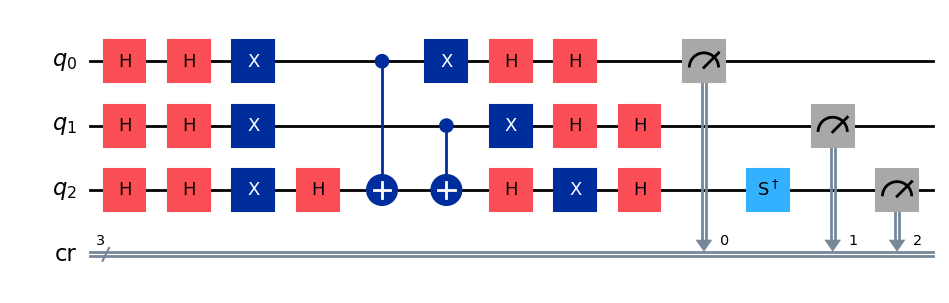

[Transpiled for Hardware] Gates: 17, Depth: 9


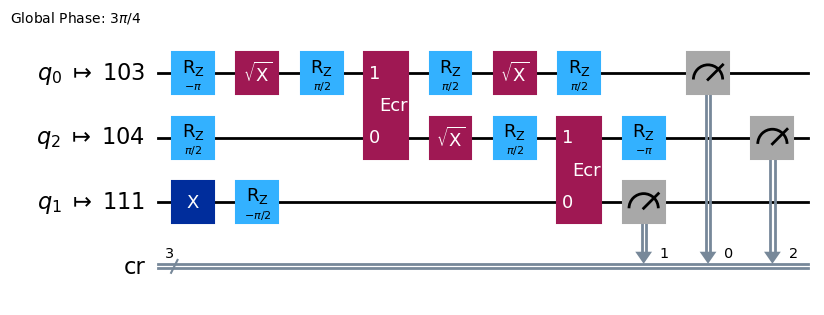

gen = 0 , Best fitness = (10.8462,)
gen = 1 , Best fitness = (0.7036,) , Number of invalids = 0
  ✓ fidelity improved to 0.7164

[Generation 1] Best Fitness: 0.7036 (Noise-Aware Simulation)
  Transpiled gates: 21.0, depth: 13.0
[Raw Circuit]


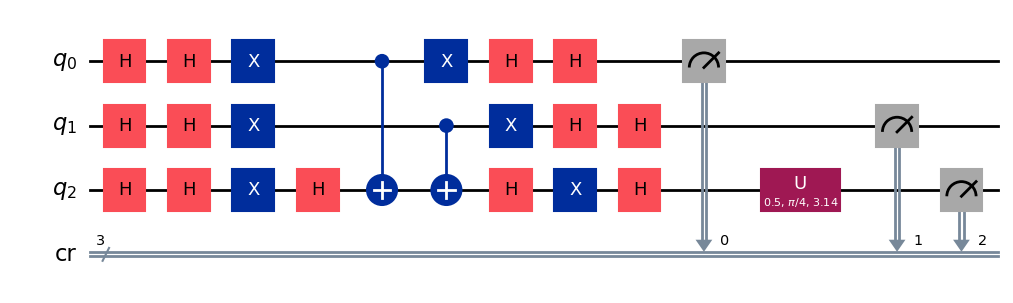

[Transpiled for Hardware] Gates: 21, Depth: 13


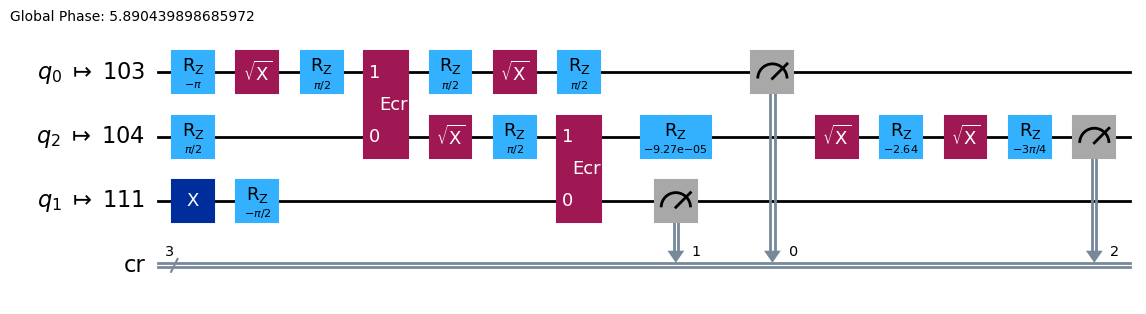

gen = 0 , Best fitness = (0.7036,)
gen = 1 , Best fitness = (0.5940000000000001,) , Number of invalids = 0

[Generation 2] Best Fitness: 0.5940 (Noise-Aware Simulation)
  Transpiled gates: 27.0, depth: 15.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


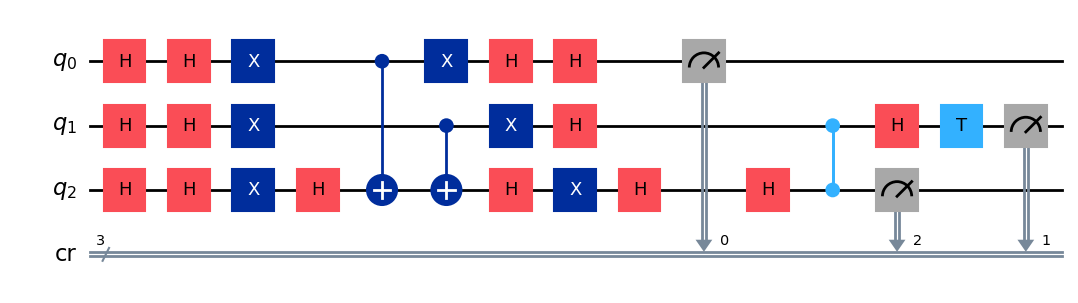

[Transpiled for Hardware] Gates: 27, Depth: 15


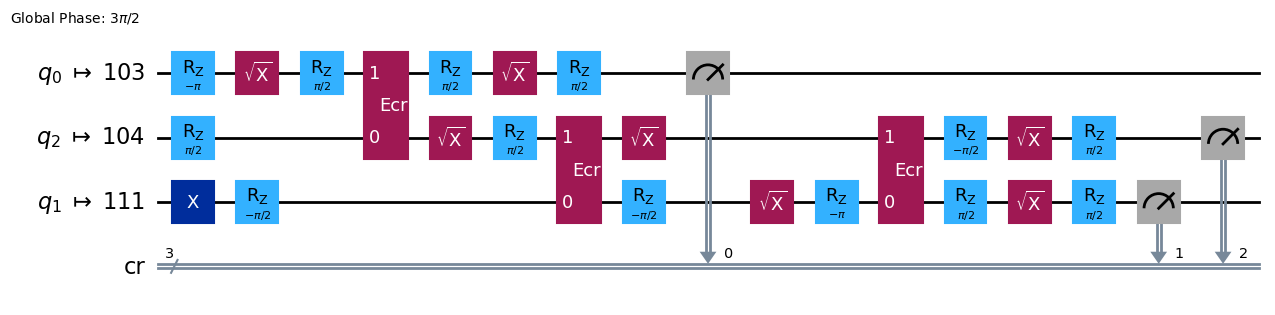

gen = 0 , Best fitness = (0.5940000000000001,)
gen = 1 , Best fitness = (0.5919,) , Number of invalids = 0
  ✓ fidelity improved to 0.8702

[Generation 3] Best Fitness: 0.5919 (Noise-Aware Simulation)
  Transpiled gates: 27.0, depth: 15.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


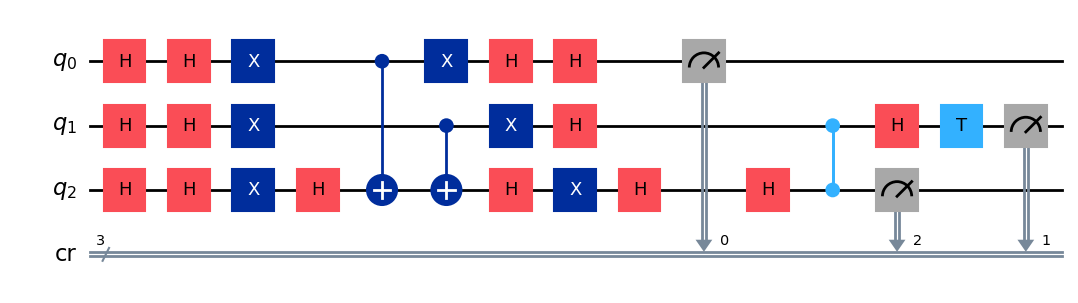

[Transpiled for Hardware] Gates: 27, Depth: 15


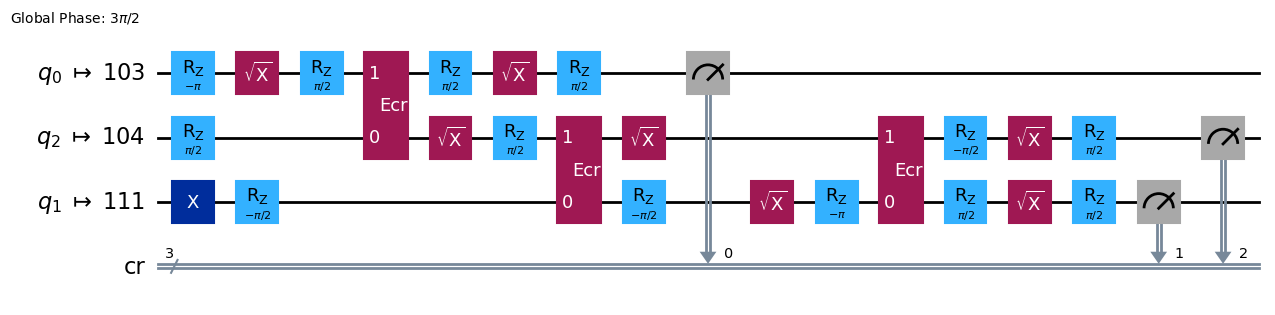

gen = 0 , Best fitness = (0.5919,)
gen = 1 , Best fitness = (0.4306,) , Number of invalids = 0
  ✓ fidelity improved to 0.9478

[Generation 4] Best Fitness: 0.4306 (Noise-Aware Simulation)
  Transpiled gates: 19.0, depth: 11.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


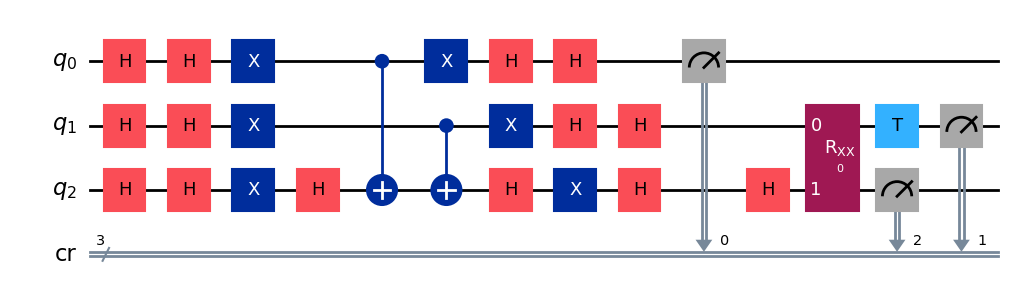

[Transpiled for Hardware] Gates: 19, Depth: 11


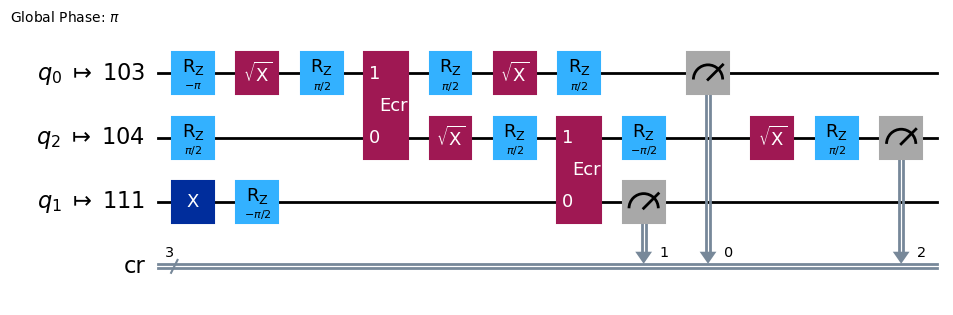

gen = 0 , Best fitness = (0.4306,)
gen = 1 , Best fitness = (0.4282,) , Number of invalids = 0
   FIDELITY TARGET ACHIEVED at generation 5!

  Early Stopping Status (Gen 5) - Phase: HARDWARE_OPTIMIZATION
  Metric       Current    Best       Target     Status Patience  
  --------------------------------------------------------------------
  Fidelity     0.9518     0.9478     0.95       ✓      1/8       
  Gates        19         17         ≤20        ✓      5/10      
  Depth        11         9          ≤15        ✓      5/10      

[Generation 5] Best Fitness: 0.4282 (Noise-Aware Simulation)
  Transpiled gates: 19.0, depth: 11.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


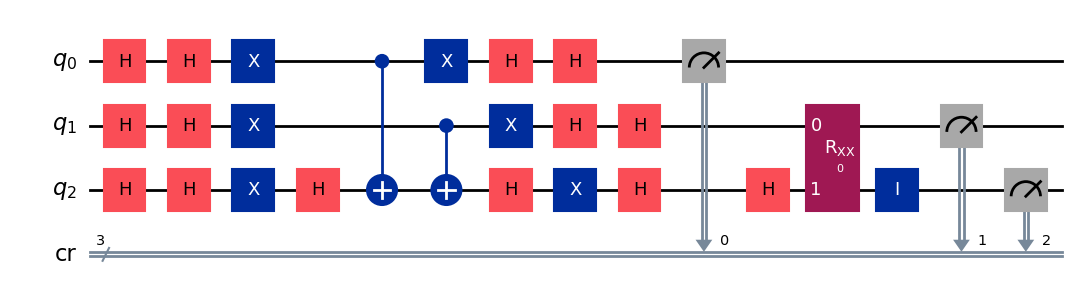

[Transpiled for Hardware] Gates: 19, Depth: 11


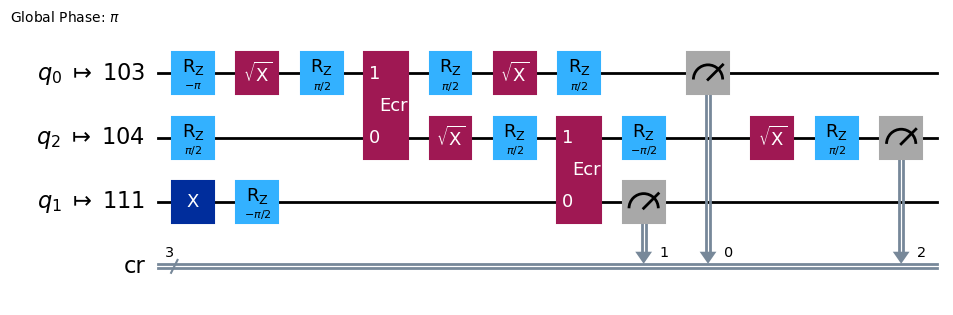

gen = 0 , Best fitness = (0.4282,)
gen = 1 , Best fitness = (0.2985,) , Number of invalids = 0
  ✓ fidelity improved to 0.9542

[Generation 6] Best Fitness: 0.2985 (Noise-Aware Simulation)
  Transpiled gates: 13.0, depth: 8.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


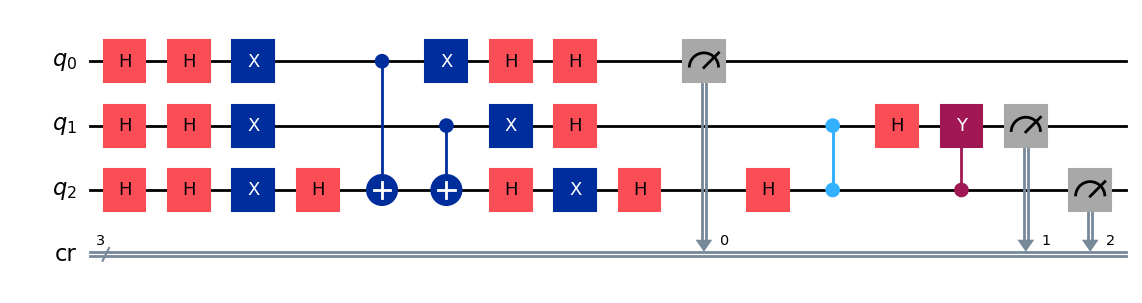

[Transpiled for Hardware] Gates: 13, Depth: 8


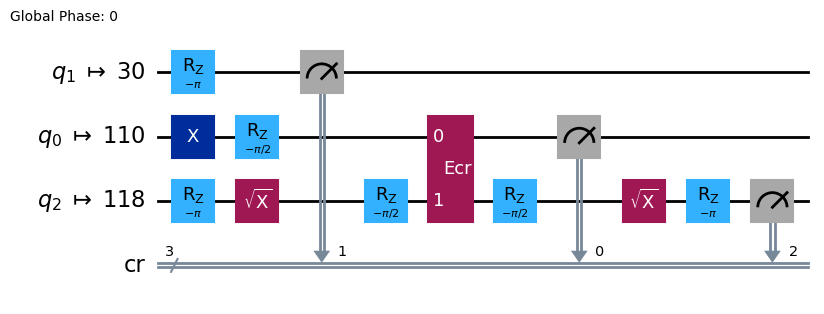

gen = 0 , Best fitness = (0.2985,)
gen = 1 , Best fitness = (0.2985,) , Number of invalids = 0
  ✓ gate_count improved to 15

[Generation 7] Best Fitness: 0.2985 (Noise-Aware Simulation)
  Transpiled gates: 13.0, depth: 8.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


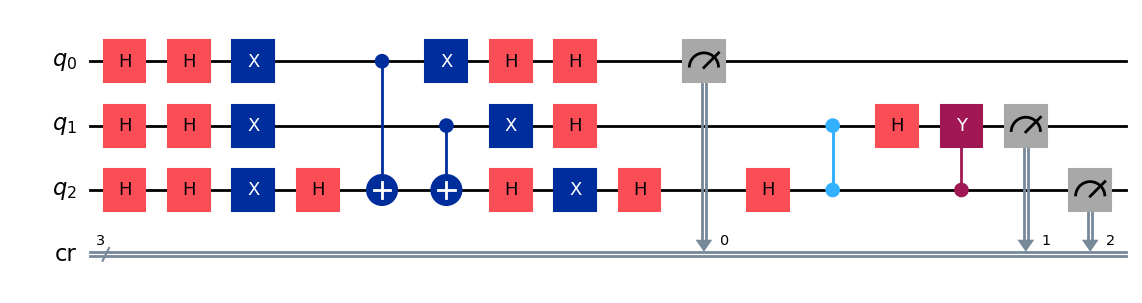

[Transpiled for Hardware] Gates: 13, Depth: 8


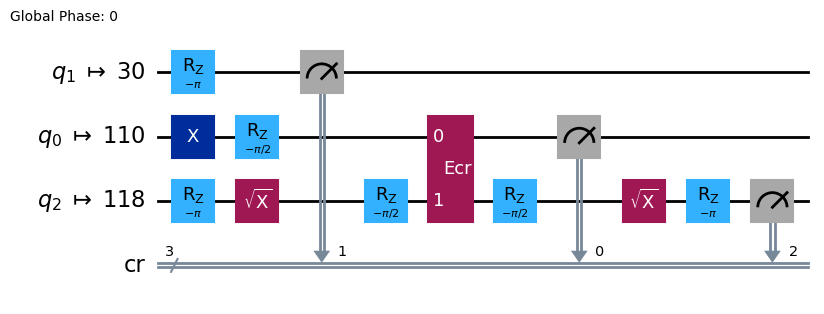

gen = 0 , Best fitness = (0.2985,)
gen = 1 , Best fitness = (0.2985,) , Number of invalids = 0
  ✓ fidelity improved to 0.9615
  ✓ gate_count improved to 13

[Generation 8] Best Fitness: 0.2985 (Noise-Aware Simulation)
  Transpiled gates: 13.0, depth: 8.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


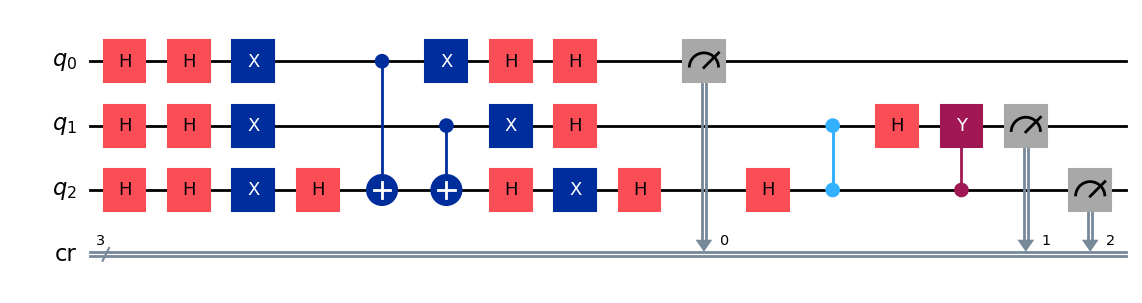

[Transpiled for Hardware] Gates: 13, Depth: 8


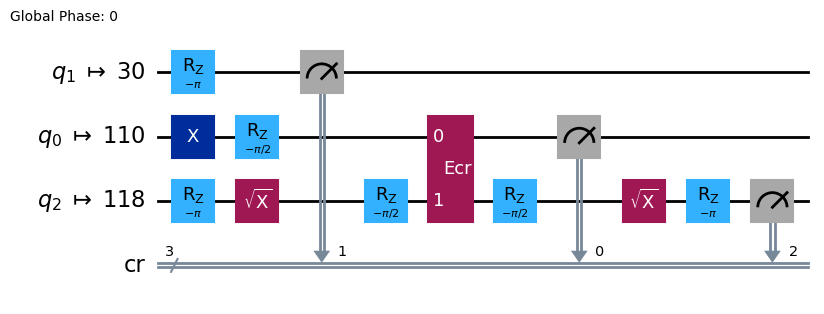

gen = 0 , Best fitness = (0.2985,)
gen = 1 , Best fitness = (0.2985,) , Number of invalids = 0

[Generation 9] Best Fitness: 0.2985 (Noise-Aware Simulation)
  Transpiled gates: 13.0, depth: 8.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


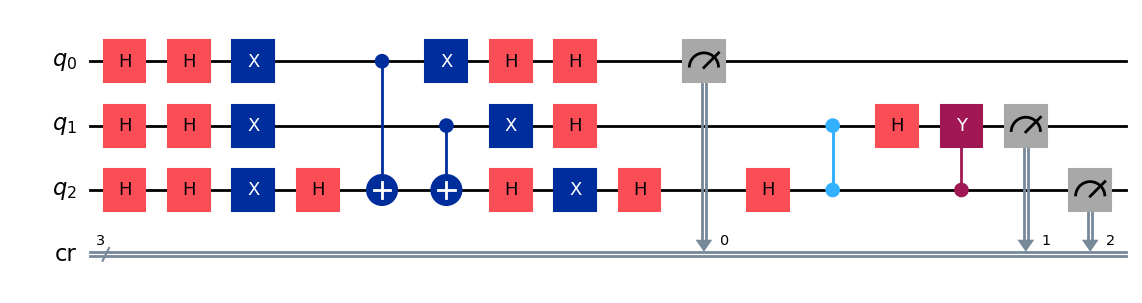

[Transpiled for Hardware] Gates: 13, Depth: 8


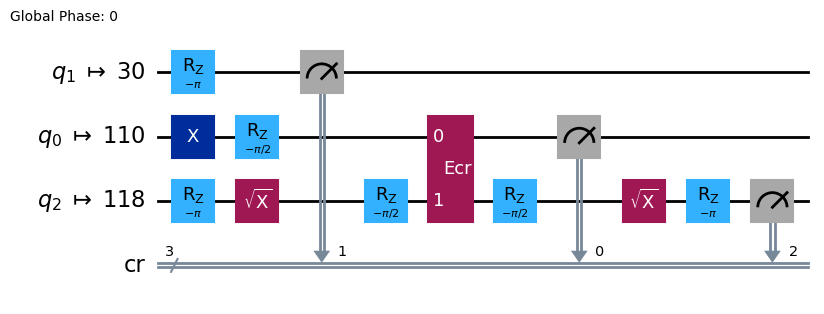

✓ Checkpoint saved: checkpoints_ibm_noise_000_ibm_brisbane/checkpoint_gen_9.pkl
✓ Latest updated:   checkpoints_ibm_noise_000_ibm_brisbane/checkpoint_latest.pkl
gen = 0 , Best fitness = (0.2985,)
gen = 1 , Best fitness = (0.2985,) , Number of invalids = 0

  Early Stopping Status (Gen 10) - Phase: HARDWARE_OPTIMIZATION
  Metric       Current    Best       Target     Status Patience  
  --------------------------------------------------------------------
  Fidelity     0.9615     0.9615     0.95       ✓      2/8       
  Gates        13         13         ≤20        ✓      2/10      
  Depth        8          9          ≤15        ✓      10/10     

[Generation 10] Best Fitness: 0.2985 (Noise-Aware Simulation)
  Transpiled gates: 13.0, depth: 8.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


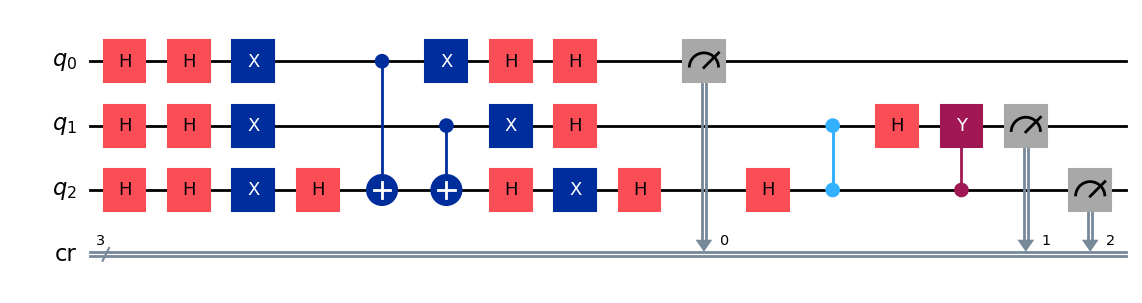

[Transpiled for Hardware] Gates: 13, Depth: 8


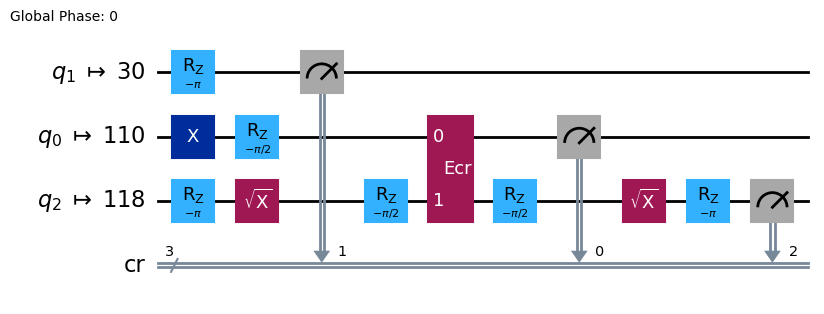

gen = 0 , Best fitness = (0.2985,)
gen = 1 , Best fitness = (0.2974,) , Number of invalids = 0

[Generation 11] Best Fitness: 0.2974 (Noise-Aware Simulation)
  Transpiled gates: 13.0, depth: 8.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


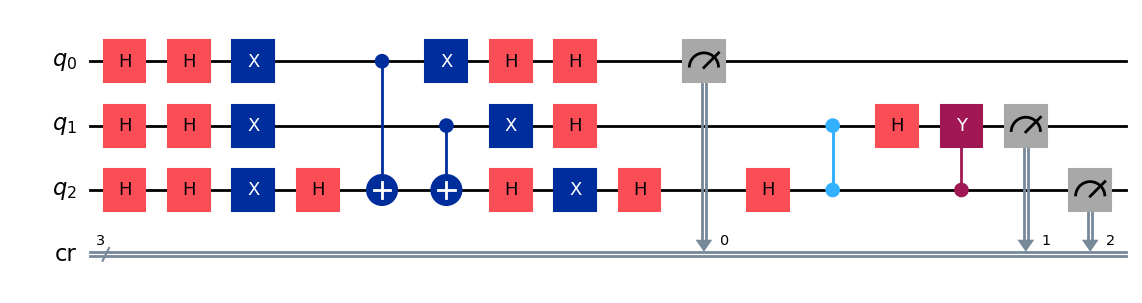

[Transpiled for Hardware] Gates: 13, Depth: 8


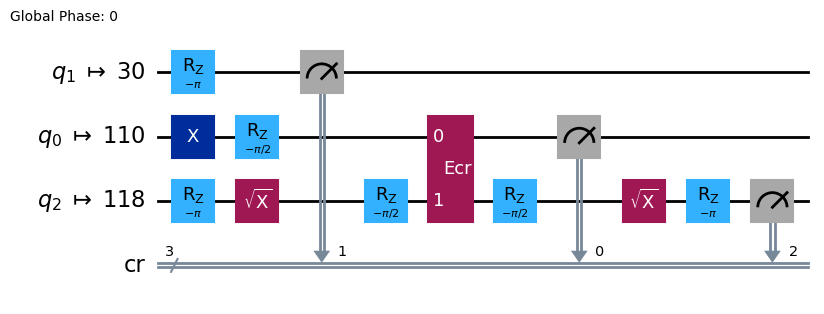

gen = 0 , Best fitness = (0.2974,)
gen = 1 , Best fitness = (0.2935,) , Number of invalids = 0

[Generation 12] Best Fitness: 0.2935 (Noise-Aware Simulation)
  Transpiled gates: 13.0, depth: 8.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


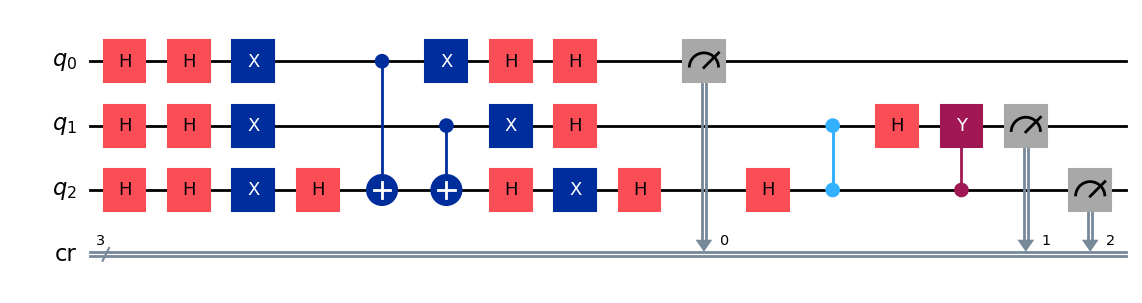

[Transpiled for Hardware] Gates: 13, Depth: 8


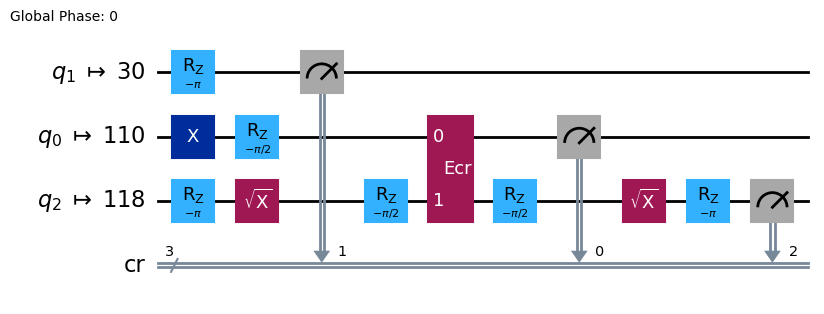

gen = 0 , Best fitness = (0.2935,)
gen = 1 , Best fitness = (0.2925,) , Number of invalids = 0

[Generation 13] Best Fitness: 0.2925 (Noise-Aware Simulation)
  Transpiled gates: 13.0, depth: 8.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


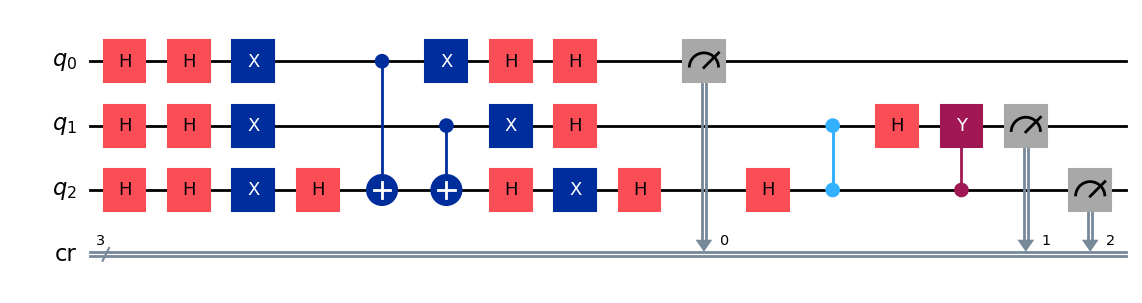

[Transpiled for Hardware] Gates: 13, Depth: 8


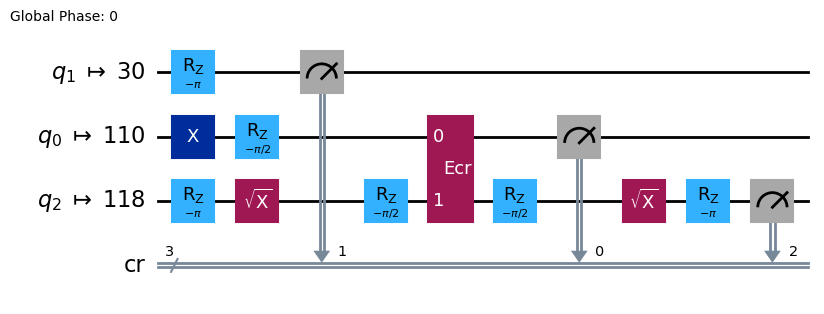

gen = 0 , Best fitness = (0.2925,)
gen = 1 , Best fitness = (0.2925,) , Number of invalids = 0
  ✓ fidelity improved to 0.9672

[Generation 14] Best Fitness: 0.2925 (Noise-Aware Simulation)
  Transpiled gates: 13.0, depth: 8.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


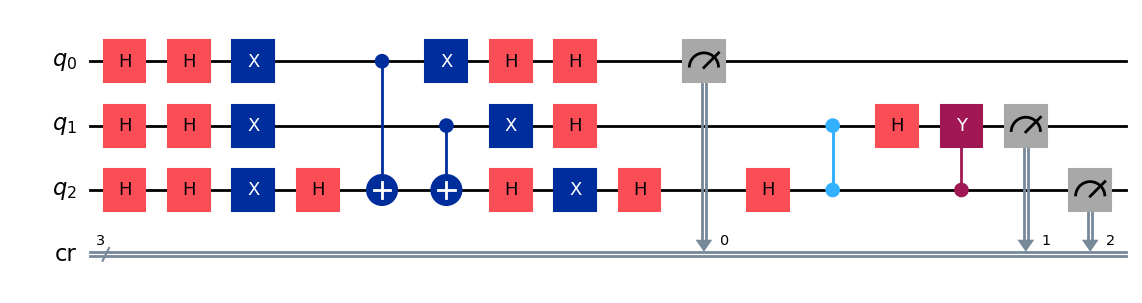

[Transpiled for Hardware] Gates: 13, Depth: 8


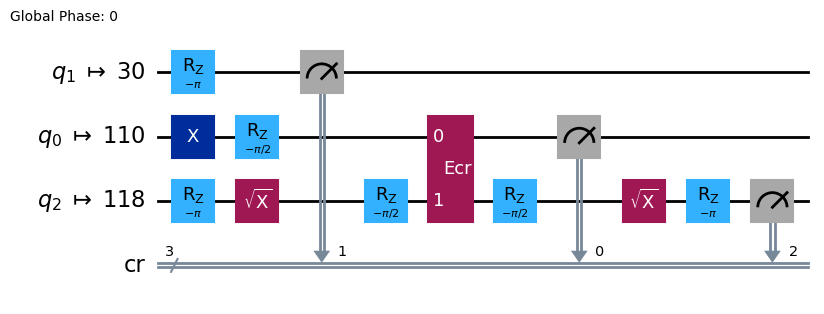

gen = 0 , Best fitness = (0.2925,)
gen = 1 , Best fitness = (0.2925,) , Number of invalids = 0

  Early Stopping Status (Gen 15) - Phase: HARDWARE_OPTIMIZATION
  Metric       Current    Best       Target     Status Patience  
  --------------------------------------------------------------------
  Fidelity     0.9675     0.9672     0.95       ✓      1/8       
  Gates        13         13         ≤20        ✓      7/10      
  Depth        8          9          ≤15        ✓      15/10     

[Generation 15] Best Fitness: 0.2925 (Noise-Aware Simulation)
  Transpiled gates: 13.0, depth: 8.0
[Raw Circuit]


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_94288/4238159647.py:91: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = (best_value - current_value) / abs(best_value)


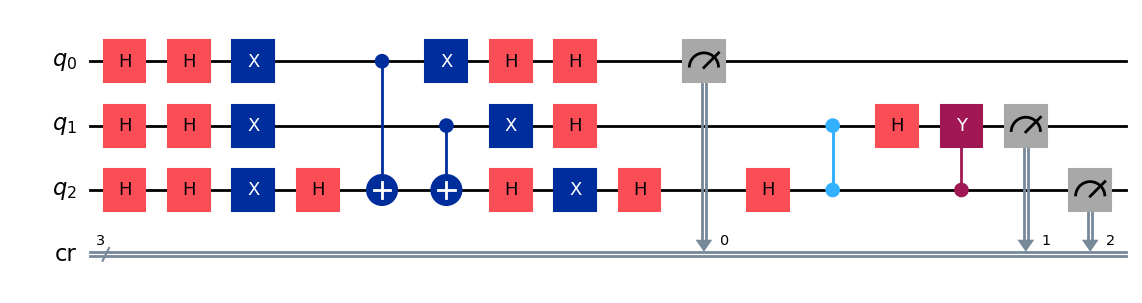

[Transpiled for Hardware] Gates: 13, Depth: 8


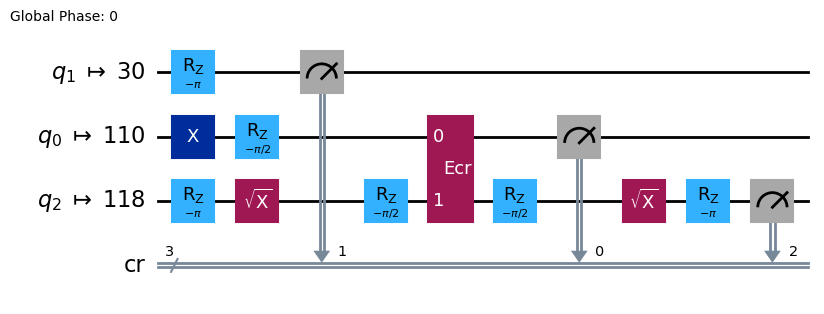


EARLY STOPPING TRIGGERED
Reason: Hardware targets achieved: fidelity=0.968, gates=13, depth=8
✓ Checkpoint saved: checkpoints_ibm_noise_000_ibm_brisbane/checkpoint_gen_15.pkl
✓ Latest updated:   checkpoints_ibm_noise_000_ibm_brisbane/checkpoint_latest.pkl

✓ Evolution complete! Final checkpoint saved.


In [22]:
#  === RUN EVOLUTION ===
print(f"\n{'='*60}")
print("STARTING EVOLUTION")
print(f"{'='*60}\n")

try:
    for gen in range(start_gen, MAX_GENERATIONS):
        # Re-seed at the beginning of each generation for consistency
        random.seed(RANDOM_SEED + gen)
        
        # Run one generation
        population, logbook = algorithms.ge_eaSimpleWithElitism(
            population,
            toolbox,
            cxpb=P_CROSSOVER,
            mutpb=P_MUTATION,
            ngen=N_GEN,
            elite_size=ELITE_SIZE,
            bnf_grammar=BNF_GRAMMAR,
            codon_size=CODON_SIZE,
            max_tree_depth=MAX_TREE_DEPTH,
            codon_consumption=CODON_CONSUMPTION,
            report_items=['gen', 'invalid', 'avg', 'std', 'min', 'max'],
            genome_representation=GENOME_REPRESENTATION,
            stats=stats,
            halloffame=hof,
            verbose=False
        )

        # Get best individual
        best_ind = tools.selBest(population, 1)[0]
        best_ind.generation = gen

        # Evaluate best individual
        best_phenotype = evaluator.decode_individual(best_ind)
        if best_phenotype is not None:
            genome_hash = hash(tuple(best_ind.genome))
            individual_seed = (RANDOM_SEED + genome_hash) % (2**32)
            
            fitness_val, logs = fitness_function_qiskit(
                best_phenotype, 
                shots=NUM_SHOTS, 
                threshold=SUCCESS_THRESHOLD, 
                gate_penalty_weight=GATE_PENALTY_WEIGHT,
                target_state=TARGET_STATE, 
                log_states=True,
                individual_seed=individual_seed,
                use_noise=USE_NOISE_MODEL,
            )
            best_fitness_list.append(fitness_val)
            
            if logs:
                avg_gate = np.mean([log["gate_count"] for log in logs])
                avg_depth = np.mean([log["depth"] for log in logs])
                p_marked = logs[0]["p_marked"]
            else:
                avg_gate = 0
                avg_depth = 0
                p_marked = 0
                
            avg_gate_count_list.append(avg_gate)
            generations_list.append(gen)
            
            # Update early stopping monitor
            if USE_EARLY_STOPPING and early_stopping_monitor:
                metrics = {
                    'fitness': fitness_val,
                    'fidelity': p_marked,
                    'gate_count': avg_gate,
                    'depth': avg_depth
                }
                early_stopping_monitor.update(gen, metrics)

        # Display progress
        # Display progress
        qc = evaluator.execute_circuit(best_phenotype)
        if qc:
            sim_type = "Noise-Aware" if USE_NOISE_MODEL else "Ideal"
            print(f"\n[Generation {gen}] Best Fitness: {best_ind.fitness.values[0]:.4f} ({sim_type} Simulation)")
            
            if USE_NOISE_MODEL:
                # With noise: Show both raw and transpiled
                print(f"  Transpiled gates: {avg_gate:.1f}, depth: {avg_depth:.1f}")
                
                print("[Raw Circuit]")
                display(qc.draw("mpl"))
                
                try:
                    transpiled_qc = transpile(qc, backend=backend, optimization_level=3)
                    print(f"[Transpiled for Hardware] Gates: {transpiled_qc.size()}, Depth: {transpiled_qc.depth()}")
                    display(transpiled_qc.draw("mpl", idle_wires=False))
                except Exception as e:
                    print(f"[Transpile Error] {e}")
            else:
                # Without noise: Show only raw circuit
                print(f"  Raw gates: {avg_gate:.1f}, depth: {avg_depth:.1f}")
                print("[Raw Circuit]")
                display(qc.draw("mpl"))
        
        # Save checkpoint periodically
        if (gen + 1) % CHECKPOINT_FREQUENCY == 0:
            save_checkpoint(population, gen, hof, best_fitness_list, 
                          avg_gate_count_list, generations_list, early_stopping_monitor)
        
        # Check early stopping
        if USE_EARLY_STOPPING and early_stopping_monitor:
            should_stop, reason = early_stopping_monitor.should_stop()
            if should_stop:
                print(f"\n{'='*60}")
                print(f"EARLY STOPPING TRIGGERED")
                print(f"Reason: {reason}")
                print(f"{'='*60}")
                early_stopping_monitor.stop_triggered = True
                early_stopping_monitor.stop_reason = reason
                early_stopping_monitor.metrics_at_stop = {
                    'fitness': fitness_val,
                    'fidelity': p_marked,
                    'gate_count': avg_gate,
                    'depth': avg_depth
                }
                break
            
except KeyboardInterrupt:
    print("\n" + "="*60)
    print("Evolution interrupted by user!")
    print("="*60)
    save_checkpoint(population, gen, hof, best_fitness_list, 
                   avg_gate_count_list, generations_list, early_stopping_monitor)
    print("Checkpoint saved. You can resume later.")
    
except Exception as e:
    print(f"\nError during evolution: {e}")
    save_checkpoint(population, gen, hof, best_fitness_list, 
                   avg_gate_count_list, generations_list, early_stopping_monitor)
    print("Checkpoint saved due to error.")
    raise

finally:
    # Clean up multiprocessing pool
    if 'pool' in locals():
        pool.close()
        pool.join()

# Save final checkpoint
save_checkpoint(population, gen, hof, best_fitness_list, 
               avg_gate_count_list, generations_list, early_stopping_monitor)
print("\n✓ Evolution complete! Final checkpoint saved.")

## Results Analysis and Visualization


EVOLUTION RESULTS

[HALL OF FAME]
Simulation Type: Noise-Aware

Individual 1:
Fitness: 0.2925

Marked State: 000
Noise-Aware simulation - p(marked): 0.9675, error: 0.0325
Transpiled Gate Count: 13, Depth: 8


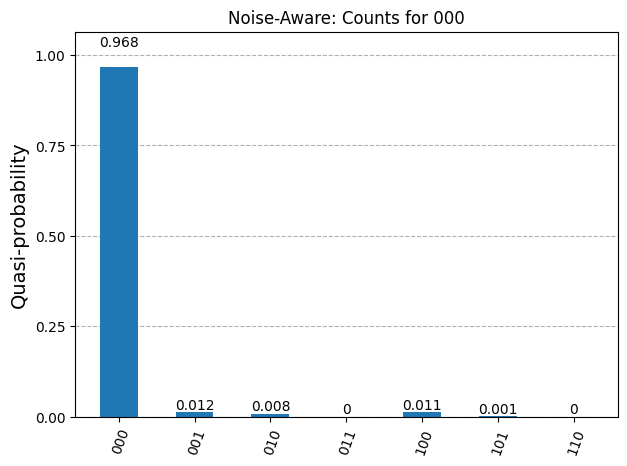


[Final Best Circuit: Raw] (Noise-Aware Simulation)


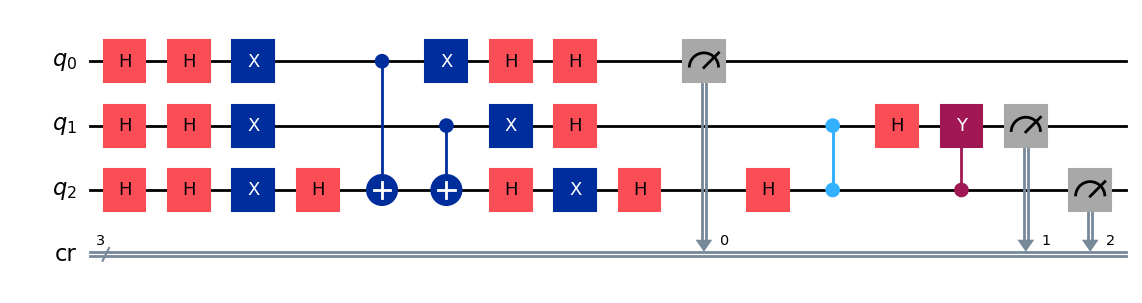


[Final Best Circuit: Transpiled for Hardware]
Gates: 13, Depth: 8


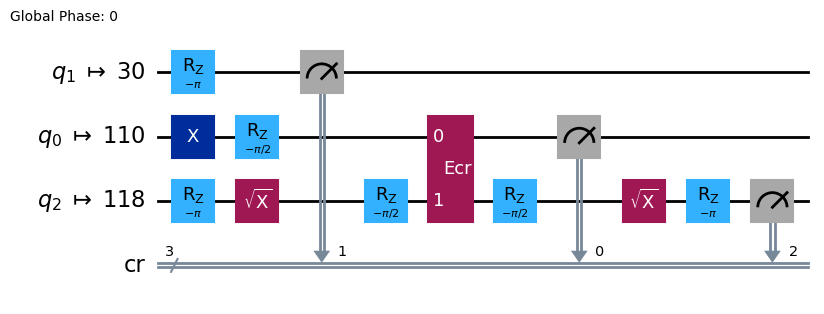


Best Individual's Fitness: 0.2925


In [23]:
# === RESULTS ANALYSIS ===
print(f"\n{'='*60}")
print("EVOLUTION RESULTS")
print(f"{'='*60}")

# Display Hall of Fame
print("\n[HALL OF FAME]")
sim_type_label = "Noise-Aware" if USE_NOISE_MODEL else "Ideal"
print(f"Simulation Type: {sim_type_label}")

for i, hof_ind in enumerate(hof.items):
    print(f"\nIndividual {i+1}:")
    print(f"Fitness: {hof_ind.fitness.values[0]:.4f}")

# Analyze best individual
best_ind = hof.items[0]
best_phenotype = evaluator.decode_individual(best_ind)

genome_hash = hash(tuple(best_ind.genome))
individual_seed = (RANDOM_SEED + genome_hash) % (2**32)

fitness, log_per_state = fitness_function_qiskit(
    best_phenotype, 
    log_states=True,
    individual_seed=individual_seed,
    use_noise=USE_NOISE_MODEL,
)

evaluator.log_evaluation(log_per_state, gen, best_ind)

for log_entry in log_per_state:
    print(f"\nMarked State: {log_entry['state']}")
    print(f"{sim_type_label} simulation - p(marked): {log_entry['p_marked']:.4f}, error: {log_entry['error']:.4f}")
    
    # Always showing hardware-transpiled metrics
    if USE_NOISE_MODEL:
        print(f"Transpiled Gate Count: {log_entry['gate_count']}, Depth: {log_entry['depth']}")
    else:
        print(f"Raw Gate Count: {log_entry['gate_count']}, Depth: {log_entry['depth']}")
    
    fig = plot_distribution(log_entry["counts"], title=f"{sim_type_label}: Counts for {log_entry['state']}")
    display(fig)

# Display best circuit
best_circuit = evaluator.execute_circuit(best_phenotype)
if best_circuit:
    print(f"\n[Final Best Circuit: Raw] ({sim_type_label} Simulation)")
    display(best_circuit.draw("mpl"))
    
    if USE_NOISE_MODEL:
        try:
            transpiled_circuit = transpile(best_circuit, backend=backend, optimization_level=3)
            print(f"\n[Final Best Circuit: Transpiled for Hardware]")
            print(f"Gates: {transpiled_circuit.size()}, Depth: {transpiled_circuit.depth()}")
            display(transpiled_circuit.draw("mpl", idle_wires=False))
        except Exception as e:
            print(f"[Transpile Error] {e}")

print(f"\nBest Individual's Fitness: {best_ind.fitness.values[0]:.4f}")

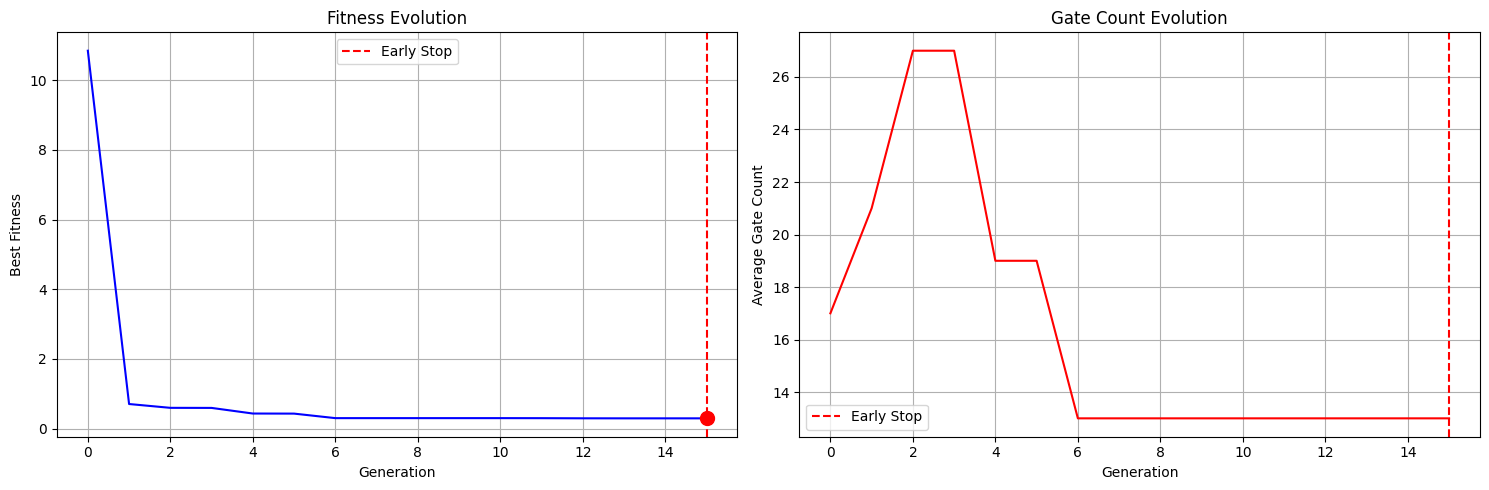


EARLY STOPPING REPORT

✓ Early stopping triggered successfully
  Stopped at generation: 15
  Reason: Hardware targets achieved: fidelity=0.968, gates=13, depth=8
  Generations saved: 35


In [24]:
# Plot evolution progress
if generations_list and best_fitness_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Fitness over generations
    ax1.plot(generations_list, best_fitness_list, 'b-')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Best Fitness')
    ax1.set_title('Fitness Evolution')
    ax1.grid(True)
    
    # Add early stopping marker if applicable
    if USE_EARLY_STOPPING and early_stopping_monitor and early_stopping_monitor.stop_triggered:
        stop_gen = early_stopping_monitor.current_generation
        if stop_gen in generations_list:
            idx = generations_list.index(stop_gen)
            ax1.axvline(x=stop_gen, color='r', linestyle='--', label='Early Stop')
            ax1.plot(stop_gen, best_fitness_list[idx], 'ro', markersize=10)
            ax1.legend()
    
    # Gate count over generations
    ax2.plot(generations_list, avg_gate_count_list, 'r-')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Average Gate Count')
    ax2.set_title('Gate Count Evolution')
    ax2.grid(True)
    
    if USE_EARLY_STOPPING and early_stopping_monitor and early_stopping_monitor.stop_triggered:
        stop_gen = early_stopping_monitor.current_generation
        if stop_gen in generations_list:
            ax2.axvline(x=stop_gen, color='r', linestyle='--', label='Early Stop')
            ax2.legend()
    
    plt.tight_layout()
    display(fig)
    plt.close(fig)

# %%
# Early Stopping Report
if USE_EARLY_STOPPING and early_stopping_monitor:
    print("\n" + "="*60)
    print("EARLY STOPPING REPORT")
    print("="*60)
    
    if early_stopping_monitor.stop_triggered:
        print(f"\n✓ Early stopping triggered successfully")
        print(f"  Stopped at generation: {early_stopping_monitor.current_generation}")
        print(f"  Reason: {early_stopping_monitor.stop_reason}")
        print(f"  Generations saved: {MAX_GENERATIONS - early_stopping_monitor.current_generation}")
    else:
        print(f"\n✗ Early stopping not triggered")
        print(f"  Completed all {MAX_GENERATIONS} generations")


In [25]:
# Display available checkpoints
print(f"\n{'='*60}")
print("AVAILABLE CHECKPOINTS")
print(f"{'='*60}")

if os.path.exists(CHECKPOINT_DIR):
    checkpoints = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "*.pkl")))
    if checkpoints:
        print(f"\nCheckpoints in {CHECKPOINT_DIR}:")
        for cp in checkpoints:
            file_size = os.path.getsize(cp) / (1024 * 1024)  # MB
            mod_time = datetime.fromtimestamp(os.path.getmtime(cp))
            print(f"  - {os.path.basename(cp)} ({file_size:.1f} MB, {mod_time.strftime('%Y-%m-%d %H:%M')})")
    else:
        print("No checkpoints found.")
else:
    print(f"Checkpoint directory '{CHECKPOINT_DIR}' does not exist.")


AVAILABLE CHECKPOINTS

Checkpoints in checkpoints_ibm_noise_000_ibm_brisbane:
  - checkpoint_gen_15.pkl (0.1 MB, 2025-08-20 10:42)
  - checkpoint_gen_9.pkl (0.1 MB, 2025-08-20 10:37)
  - checkpoint_latest.pkl (0.1 MB, 2025-08-20 10:42)


## IBM Quantum Hardware Execution

In [26]:
def run_hof_on_ibm(evaluator, hof, target_state=TARGET_STATE):
    """
    Run Hall of Fame individuals on IBM quantum hardware (robust).
    - Disables streaming callbacks to avoid notebook stalls.
    - Submits once and awaits the same job.
    - Handles counts consistently.
    """
    print(f"\n{'='*60}")
    print("IBM QUANTUM HARDWARE EXECUTION")
    print(f"{'='*60}")
    print(f"Evolution used noise model: {'YES' if USE_NOISE_MODEL else 'NO'}")
    print(f"Target state: {target_state}")
    print(f"Shots per circuit: {evaluator.shots}")

    # Init IBM Runtime
    try:
        # Use one channel consistently; add name if you use a saved profile
        service = QiskitRuntimeService(channel="ibm_cloud")  # , name="qgss-2025"
        backend = service.backend("ibm_brisbane")
        status = backend.status()
        print(f"✓ Connected to backend: {backend.name}")
        print(f"  Status: {status}")
        try:
            print(f"  Queue: {status.pending_jobs} jobs")
        except Exception:
            pass
    except Exception as e:
        print(f"✗ Could not connect to IBM backend: {e}")
        print("  Please check your IBM account/token/instance.")
        return

    sampler = Sampler(backend=backend)
    sampler.options.default_shots = evaluator.shots

    #  IMPORTANT: disable streaming/callbacks to avoid WebSocket stalls
    try:
        sampler.options.environment.log_level = "WARNING"
        sampler.options.environment.callback = None
    except Exception:
        # Older runtimes may not expose environment options; safe to ignore
        pass

    for i, ind in enumerate(hof.items):
        print(f"\n[HOF Individual {i+1}] Fitness: {ind.fitness.values[0]:.4f}")

        pheno_code = evaluator.decode_individual(ind)
        if pheno_code is None:
            print("  ✗ Could not decode individual - skipping")
            continue

        # Ensure explicit registers if your decoder emits qc = QuantumCircuit(3,3)
        pheno_code = re.sub(
            r"qc\s*=\s*QuantumCircuit\(\s*3\s*,\s*3\s*\)",
            "qr = QuantumRegister(3, name='q')\n"
            "cr = ClassicalRegister(3, name='cr')\n"
            "qc = QuantumCircuit(qr, cr)",
            pheno_code
        )

        circuit = evaluator.execute_circuit(pheno_code)
        if circuit is None:
            print("  ✗ Invalid circuit - skipping")
            continue

        print("\nEvolved circuit statistics:")
        print(f"  Original gates: {circuit.size()}")
        print(f"  Original depth: {circuit.depth()}")
        print(f"  Gate counts: {circuit.count_ops()}")

        print("\nOriginal evolved circuit:")
        display(circuit.draw("mpl"))
        plt.close()  # prevent figure buildup

        # Transpile
        print(f"\nTranspiling circuit for {backend.name}...")
        try:
            pm = generate_preset_pass_manager(
                target=backend.target,
                optimization_level=3,
                seed_transpiler=RANDOM_SEED  # makes transpilation consistent
            )
            circuit_isa = pm.run(circuit)
            print("✓ Circuit transpiled successfully!")

            print("\nTranspiled circuit statistics:")
            print(f"  Transpiled gates: {circuit_isa.size()}")
            print(f"  Transpiled depth: {circuit_isa.depth()}")
            print(f"  Gate counts: {circuit_isa.count_ops()}")
            try:
                print(f"  Gate reduction: {((circuit.size() - circuit_isa.size()) / circuit.size() * 100):.1f}%")
                print(f"  Depth reduction: {((circuit.depth() - circuit_isa.depth()) / circuit.depth() * 100):.1f}%")
            except ZeroDivisionError:
                pass

            print("\nTranspiled circuit for hardware:")
            display(circuit_isa.draw(output="mpl", idle_wires=False))
            plt.close()
        except Exception as transpile_error:
            print(f"✗ Circuit transpilation failed: {transpile_error}")
            continue

        # Submit once, await that job
        print(f"\nSubmitting job to {backend.name}...")
        print(f"  Requested shots: {evaluator.shots}")

        try:
            job = sampler.run([circuit_isa])
            print("✓ Job submitted.")
            print(f"  Job ID: {job.job_id()}")
            print("  Waiting for results...")

            # Add a timeout to avoid indefinite waits (adjust as needed)
            result = job.result(timeout=1800)  # seconds

            # Extract counts (same structure as your working notebook)
            data_bin = result[0]["__value__"]["data"]
            counts = data_bin.cr.get_counts()
            # Reverse bitstrings if needed to match your target convention
            counts = {k[::-1]: v for k, v in counts.items()}

            # Compute metrics
            total = sum(counts.values())
            p_marked = counts.get(target_state, 0) / total if total > 0 else 0.0

            print(f"\n✓ Hardware execution completed!")
            print(f"  Total shots processed: {total}")
            print(f"  Hardware p(marked) for {target_state}: {p_marked:.4f}")
            print(f"  Measurement distribution: {counts}")

            # Plot + display
            fig = plot_distribution(counts, title=f"HOF #{i+1} on {backend.name} - {total} shots")
            display(fig)
            plt.close(fig)

            # Compare to evolution fitness (ensure these names are in scope)
            evolution_fitness = ind.fitness.values[0]
            error_hw = 1 - p_marked
            miss_hw = 1 if error_hw > SUCCESS_THRESHOLD else 0
            gate_penalty_hw = GATE_PENALTY_WEIGHT * circuit_isa.size()
            fitness_hw = 10 * miss_hw + error_hw + gate_penalty_hw

            print("\n  Performance comparison:")
            print(f"    Evolution fitness: {evolution_fitness:.4f}")
            print(f"    Hardware  fitness: {fitness_hw:.4f}")
            if fitness_hw < evolution_fitness:
                print(f"    Hardware shows better performance: {(evolution_fitness - fitness_hw):.4f}")
            elif fitness_hw > evolution_fitness:
                print(f"    ⚠ Hardware shows degradation: {(fitness_hw - evolution_fitness):.4f}")
            else:
                print("    ≡ Equivalent performance")

            # Persist results
            hw_data = {
                "individual_id": i + 1,
                "fitness_evolution": float(evolution_fitness),
                "fitness_hardware": float(fitness_hw),
                "backend": backend.name,
                "target_state": target_state,
                "counts": counts,
                "p_marked_hw": p_marked,
                "total_shots": total,
                "original_gates": circuit.size(),
                "original_depth": circuit.depth(),
                "transpiled_gates": circuit_isa.size(),
                "transpiled_depth": circuit_isa.depth(),
                "job_id": job.job_id(),
                "timestamp": datetime.now().isoformat(),
            }

            os.makedirs(LOG_DIR, exist_ok=True)
            json_path = os.path.join(LOG_DIR, f"hof_{i+1}_ibm_hardware_data.json")
            with open(json_path, "w") as f:
                json.dump(hw_data, f, indent=2)
            print(f"  Results saved to: {json_path}")

        except Exception as execution_error:
            print(f"✗ Hardware execution failed: {execution_error}")
            print("  This could be due to:")
            print("    - Backend queue / transient network issues")
            print("    - Streaming callbacks (already disabled here)")
            print("    - Session/runtime mismatches")
            continue

    print(f"\n{'='*60}")
    print("IBM Quantum hardware execution completed!")
    print(f"Note: Results from real quantum hardware at {backend.name}")
    print(f"{'='*60}")


IBM QUANTUM HARDWARE EXECUTION
Evolution used noise model: YES
Target state: 000
Shots per circuit: 10000
✓ Connected to backend: ibm_brisbane
  Status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x168175f30>
  Queue: 1802 jobs

[HOF Individual 1] Fitness: 0.2925

Evolved circuit statistics:
  Original gates: 27
  Original depth: 14
  Gate counts: OrderedDict([('h', 14), ('x', 6), ('measure', 3), ('cx', 2), ('cz', 1), ('cy', 1)])

Original evolved circuit:


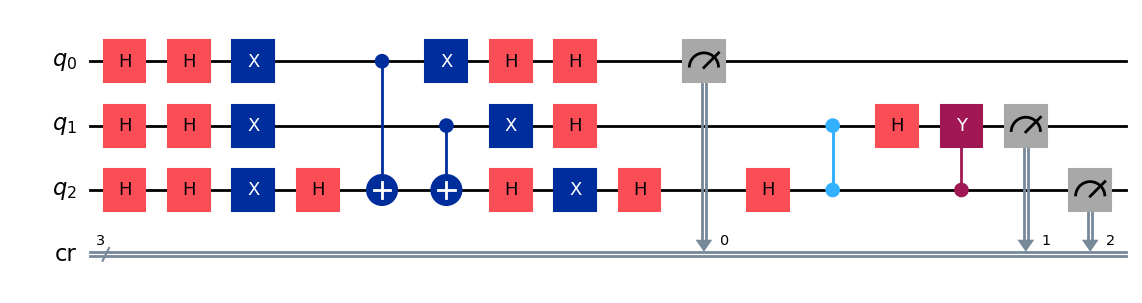


Transpiling circuit for ibm_brisbane...
✓ Circuit transpiled successfully!

Transpiled circuit statistics:
  Transpiled gates: 13
  Transpiled depth: 8
  Gate counts: OrderedDict([('rz', 6), ('measure', 3), ('sx', 2), ('x', 1), ('ecr', 1)])
  Gate reduction: 51.9%
  Depth reduction: 42.9%

Transpiled circuit for hardware:


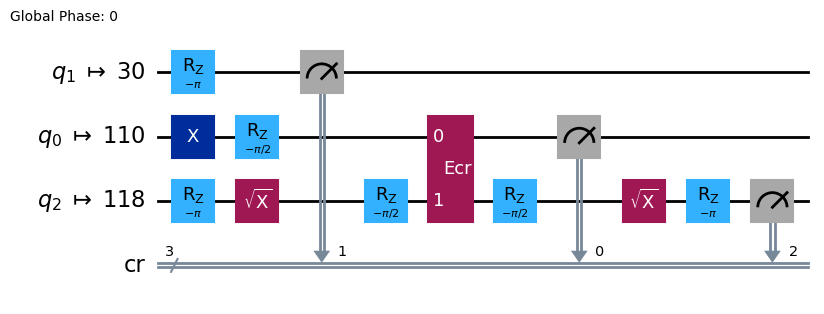


Submitting job to ibm_brisbane...
  Requested shots: 10000
✓ Job submitted.
  Job ID: d2ipgvuactes73f6gnb0
  Waiting for results...


base_runtime_job._start_websocket_client:WARNING:2025-08-20 10:47:41,389: An error occurred while streaming results from the server for job d2ipgvuactes73f6gnb0:
Traceback (most recent call last):
  File "/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 314, in _start_websocket_client
    self._ws_client.job_results()
  File "/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/api/clients/base_websocket_client.py", line 222, in stream
    raise WebsocketError(error_message)
qiskit_ibm_runtime.api.exceptions.WebsocketError: 'Max retries exceeded


✓ Hardware execution completed!
  Total shots processed: 10000
  Hardware p(marked) for 000: 0.9731
  Measurement distribution: {'000': 9731, '100': 97, '010': 65, '001': 91, '101': 13, '110': 2, '011': 1}


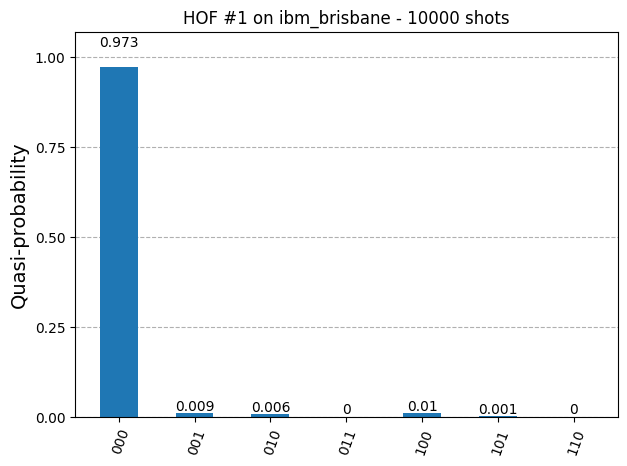


  Performance comparison:
    Evolution fitness: 0.2925
    Hardware  fitness: 0.2869
    Hardware shows better performance: 0.0056
  Results saved to: logs_marked_state_IBM_ibm_brisbane_000_10000_noise/hof_1_ibm_hardware_data.json

IBM Quantum hardware execution completed!
Note: Results from real quantum hardware at ibm_brisbane


In [27]:
run_hof_on_ibm(evaluator, hof, target_state=TARGET_STATE)